In [12]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import colors as clr
import numpy as np
import sys
import re
import fileinput
from scipy.optimize import curve_fit
import operator
#import scipy as scp


# function to change OUTPUT file into space-separated float fields and parameterise the data using this new format
# line in 'with open' bit is type 'str'

# create a function to get spectral grid data

oldstr = ['0-','1-','2-','3-','4-','5-','6-','7-','8-','9-']
newstr = ['0 -','1 -','2 -','3 -','4 -','5 -','6 -','7 -','8 -','9 -']

def data_read_gaia(f):
    missed_line_inds = []
    temp_data = []
    check = 0
    #number of lines to cut = number of line containing 'convective shell' label - (2 + any additional string lines)
    for line in f:
        for i in range(len(oldstr)):
            line = line.replace(oldstr[i],newstr[i])
        check = check + 1
        for x in range(4,1,-1):
            line = line.replace((x*' '),' ')
        line = line.replace('D','E')
        match_ast = re.search('[**]', line)
        match_inf = re.search('Infinity',line)
        if match_ast or match_inf or (line.strip()==''):
            missed_line_inds.append(check)
            #continue
        else:
            file_data = np.array([float(parameter) for parameter in line.strip().split(' ')])
            temp_data.append(file_data)
    out_all_data = np.array(temp_data)

    print 'Total dataset: ',out_all_data.shape
    return out_all_data

# select the parameter (Teff or log(g) for each array(file)) with which to analyse the filter profiles,
# by setting the other to be constant, using the column number (integer)
def grid_vals_dict(input_arr,col_numb):
    col_vals = []
    col_var_arrs = {}
    # create list of values of the column NOT being examined
    for i in range(len(input_arr[:,(col_numb - 1)])):
        if (input_arr[i,(col_numb - 1)] not in col_vals):
            col_vals.append(input_arr[i,(col_numb - 1)])
    print 'Table column ',col_numb,' values list: ',col_vals
    # create arrays for fixed values of col_numb parameter
    for j in col_vals:
        temp_k_list = []
        for k in range(len(input_arr[:,(col_numb - 1)])):
            if (input_arr[k,(col_numb - 1)] == j):
                temp_k_list.append(input_arr[k,:])
        temp_k_array = np.array(temp_k_list)
        #print 'For column',col_numb,'value of',j,', the array has the following shape: ',temp_k_array.shape
        col_var_arrs[str(j)] = temp_k_array
    print 'Final dictionary length: ',len(col_var_arrs)
    return col_var_arrs, col_vals

   
def diff_grid_dict(dict_Av0,dict_Avne0):
    diff_dict = {}
    # use sets to match keys in dictionaries
    combined_set = set(dict_Av0).intersection(set(dict_Avne0))
    print 'combined set size:',len(combined_set)
    for key_val in combined_set:
        #print key_val
        # use variables to store each key value
        Av0_arr_kv = dict_Av0[key_val]
        Avne0_arr_kv = dict_Avne0[key_val]
        # take the difference of the two sets of filter magnitudes for different calibrations of BCs
        # gives absolute extinction A(X) as numerical output
        diff_arr_kv = Av0_arr_kv - Avne0_arr_kv
        for n in range(len(diff_arr_kv[0,:])):
            if (n == 0 or n == 1):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                diff_arr_kv[:,n] = Av0_arr_kv[:,n]
        diff_dict[key_val] = diff_arr_kv
        if (diff_arr_kv.shape != Avne0_arr_kv.shape):
            print 'shape error'
    print 'Raw A(X) dictionary complete'
    return diff_dict

# check Casagrande dictionary - is it just the same as before? Shouldn't be!
def casa_check(A_X_dict,casa_A_X_dict,casa_Teff):
    diff_dict = {}
    offset_arr = []
    temp_arr = []
    combined_set = set(A_X_dict).intersection(set(casa_A_X_dict))
    print 'combined set size:',len(combined_set)
    for key_val in combined_set:
        A_arr_kv = A_X_dict[key_val]
        casa_arr_kv = casa_A_X_dict[key_val]
        for m in range(len(A_arr_kv[:,0])):
            for n in range(len(casa_arr_kv[:,0])):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                if ((casa_arr_kv[n,0] == A_arr_kv[m,0] and casa_arr_kv[n,1] == A_arr_kv[m,1])):
                    offset_arr.append(casa_arr_kv[n,0])
                    offset_arr.append(casa_arr_kv[n,1])
                    for j in range(2,5):
                        offset_arr.append(casa_arr_kv[n,j] - A_arr_kv[m,j])
                    temp_arr.append(offset_arr)
        diff_dict[key_val] = np.array(temp_arr)
    return diff_dict
                
# general fits write-out function

def general_fit_number_gen_write(f,func_type,func_coeffs,covar_matrix,filter_str,logg_val,avg_dict):
    frac_list = []
    output_names = ['    Fit coefficients (in order of functions'' arguments):','    Covariance matrix:']
    f.write('Fitting results for ' + str(filter_str) + ' filter, with log(g) = ' + str(logg_val) + '\n')
    f.write('Function type:  ' + func_type + '\n')
    f.write(output_names[0] + '\n')
    f.write(str(func_coeffs) + '\n')
    f.write(output_names[1] + '\n')
    f.write(str(covar_matrix) + '\n')
    f.write('Fractional errors in fit coefficients = {E[(X(i)-E[X(i)])*(X(j)-E[X(j)])]}/{|E[X(i)]*E[X(j)]|}' + '\n')
    f.write('i.e., covariance(i,j)/{coef(i)*coef(j)}' + 2*'\n')
    f.write('Fractional error output:  ' + '\n')
    # write out errors as detailed above
    
    sum_y = 0
    yterm_count = 0
    for i in range(len(func_coeffs)):
        f.write('row ' + str(i+1) + 2*'\t')
        for j in range(len(func_coeffs)):
            # use if statement to avoid repeating terms in symmetrical covariance matrix
            # should result in increasing number of entries for increasing row number
            if (j <= i):
                y = abs(covar_matrix[i][j]/(func_coeffs[i]*func_coeffs[j]))
                f.write(str(y) + '\t')
                yterm_count += 1
                sum_y += y
        f.write('\n')
    f.write('\n')
    avg_y = sum_y/yterm_count
    avg_dict[func_type] = avg_y
    f.write('Average fractional error = ' + str(avg_y) + 2*'\n')
    print 'Average fractional error for ' + func_type + ' = ' + str(avg_y)
    
# Modelling functions below!!!

# linear function
def linear_func(xdata,a,b):
    y = (a*xdata) + b
    return y

# quadratic function
def quad_func(xdata,a,b,c):
    y = a*(xdata**2) + (b*xdata) + c
    return y

# single power-law term
def single_poly(xdata,a,b,c):
    y = a*(xdata**b) + c
    return y

# exponential function
def exp_func(xdata,a,b,c):
    y = (a*(np.exp(b*xdata))) + c
    return y

# logarithmic function
def log_func(xdata,a,b,c):
    y = (a*(np.log10(b*xdata))) + c
    return y

# exponential function added to Teff^d
#def single_poly_plus_exp_func(xdata,a,b,c,d):
#    y = (xdata**d) + (a*(np.exp(b*xdata))) + c
#    return y

# Full addition of exponential function to pwoer-law
def full_pow_plus_exp_func(xdata,a,b,c,d,e):
    y = (d*(xdata**e)) + (a*(np.exp(b*xdata))) + c
    return y

# functions to reproduce Casagrande & Vandenberg (in prep.) behaviour
def casa_T4_range(Teff_vals,min_val,max_val):
    T4_list = []
    Teff_list = []
    #if (min_val in Teff_vals and max_val in Teff_vals):
    for i in Teff_vals:
        if (min_val <= i <= max_val):
            Teff_list.append(i)
            # T4 defined as Teff*(10^-4)
            T4_list.append(i*(1.0e-4))
    #else:
    T4r = np.array(T4_list)
    Teffr = np.array(Teff_list)
    return Teffr,T4r

# extinction coefficient, R_X = A(X)/E(B-V) ALWAYS!!!
# -> need to find E(B-V) values, then use to compare

# try a function to reduce oppportunities for error for stuff below
# during curve fitting - tests, plots & writes out figure, writes out results of covariance matrix analysis

# define the actual load-up of the functions to be fitted separately
def functions_loadup(function,x_coords_fit,y_coords_fit,bounds_list,coeffs_list,cov_arr_list):
    # functions_list, bounds_list MUST MATCH in their orders!! (functions and coefficient bounds, respectively)
    #for a in functions_list: # iterate between function types
    function_coeffs,covarr = curve_fit(function,x_coords_fit,y_coords_fit, p0=None, sigma=None,bounds=bounds_list)
    coeffs_list.append(function_coeffs)
    cov_arr_list.append(covarr)
    #return coeffs_list,cov_arr_list

# curve fitting function
def filter_curve_fit(A_X_zs_gfix,A_X_z2_gfix,key,metal,filter_str):
    if (metal == 'solar'):
        A_X_chosen = A_X_zs_gfix[key]
    elif (metal == 'sol_100'):
        A_X_chosen = A_X_z2_gfix[key]
    else:
        print 'Error! Incorrect metallicity input'
        A_X_chosen = []
        
    if (key == '5.0'):
        # curve-fitting commands - for log(g) = 5.0 ONLY - apply results to other log(g) values
        # store using the following lists:
        exp_fit_A_logg5_list = []
        covarr_A_logg5_ef_list = []
        pow_fit_A_logg5_list = []
        covarr_A_logg5_pow_list = []
        #spp_exp_fit_A_logg5_list = []
        #covarr_A_logg5_spp_list = []
        plpe_fit_A_logg5_list = []
        covarr_A_logg5_plpe_list = []
        
        for i in range(2,len(A_X_chosen[0,:])):
            functions_loadup(exp_func,A_X_chosen[:,0],A_X_chosen[:,i],exp_bounds[i-2],exp_fit_A_logg5_list,covarr_A_logg5_ef_list)
            functions_loadup(single_poly,A_X_chosen[:,0],A_X_chosen[:,i],pow_bounds[i-2],pow_fit_A_logg5_list,covarr_A_logg5_pow_list)
            functions_loadup(full_pow_plus_exp_func,A_X_chosen[:,0],A_X_chosen[:,i],plpe_bounds[i-2],plpe_fit_A_logg5_list,covarr_A_logg5_plpe_list)
            
            #exp_fit_A_logg5, covarr_A_logg5_ef = curve_fit(exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=exp_bounds[i-2])
            #pow_fit_A_logg5, covarr_A_logg5_pow = curve_fit(single_poly,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=pow_bounds[i-2])
            #spp_exp_fit_A_logg5, covarr_A_logg5_spp = curve_fit(single_poly_plus_exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=spp_bounds[i-2])

            
            exp_fit_A_logg5 = exp_fit_A_logg5_list[i-2]
            covarr_A_logg5_ef = covarr_A_logg5_ef_list[i-2]
            pow_fit_A_logg5 = pow_fit_A_logg5_list[i-2]
            covarr_A_logg5_pow = covarr_A_logg5_pow_list[i-2]
            plpe_fit_A_logg5 = plpe_fit_A_logg5_list[i-2]
            covarr_A_logg5_plpe = covarr_A_logg5_plpe_list[i-2]
            
            # print fitting results
            print 'Calculating coefficients & covariance matrices for ' + filter_str[i-2] + ' filter'
            
            print 'Exponential fit coefficients: '
            print exp_fit_A_logg5
            print 'Covariance matrix: '
            print covarr_A_logg5_ef

            print 'Teff^(n) fit coefficients: '
            print pow_fit_A_logg5
            print 'Covariance matrix: '
            print covarr_A_logg5_pow

            print 'Teff^(n) + exponential fit coefficients: '
            print plpe_fit_A_logg5
            print 'Covariance matrix: '
            print covarr_A_logg5_plpe
            
            print 2*'\n'
            
        print 'Number of fit operations = ', len(exp_fit_A_logg5_list)
        print 'List object type: ', type(exp_fit_A_logg5_list)
        # combine lists to store for log(g) != 5.0 function runs
        combined_list = [exp_fit_A_logg5_list,covarr_A_logg5_ef_list,pow_fit_A_logg5_list,covarr_A_logg5_pow_list,plpe_fit_A_logg5_list,covarr_A_logg5_plpe_list]
        #print combined_list
    print '\n         FITTING OPERATION COMPLETE \n'
    return combined_list

        
# plot & write results
def filter_curve_plot_write(A_X_zs_gfix,A_X_z2_gfix,combined_list,key,metal,extras,filter_str,folder,graph_fold,casa_opt,multiplot_file,zoom_min=None,zoom_max=None):
    if (metal == 'solar'):
        A_X_chosen = A_X_zs_gfix[key]
        casa_chosen = casa_arr_zs
    elif (metal == 'sol_100'):
        A_X_chosen = A_X_z2_gfix[key]
        casa_chosen = casa_arr_z2
    else:
        print 'Error! Incorrect metallicity input'
        A_X_chosen = []
    
    if (zoom_min is not None and zoom_max is not None):
        extras += ('_zoom_' + str(int(zoom_min)) + 'K_' + str(int(zoom_max)) + 'K')
    # First, double-check number of columns
    #if (len(A_X_chosen[0,:]) == len(A_X_fit[0,:])):
    #    print 'Number of columns check passed'
    
    # Hubble data: easier to use subplots -> add option
    if (multiplot_file == 'y'):
        plot_dir_str_i = None
        data_dir_str_i = None
        fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
        axs = axs.ravel()
        # Write out to new file: first 'with' statement empties the file to be written into later
        data_dir_str_i = folder + '/Teff_AHub_gaia_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers.txt'
        if (key == '5.0'):
            with open (data_dir_str_i,'w') as f:
                f.close()
        # Iteration for changes BETWEEN filters !!!
        for i in range(2,len(A_X_chosen[0,:])):
            # curve-fitting commands - for log(g) = 5.0 ONLY - apply results to other log(g) values
            # use lists filled in before (for log(g) = 5.0) to provide fit-curve data
            exp_fit_A_logg5 = (combined_list[0])[i-2]
            covarr_A_logg5_ef = (combined_list[1])[i-2]
            pow_fit_A_logg5 = (combined_list[2])[i-2]
            covarr_A_logg5_pow = (combined_list[3])[i-2]
            plpe_fit_A_logg5 = (combined_list[4])[i-2]
            covarr_A_logg5_plpe = (combined_list[5])[i-2]
            
            # check that fitting numbers are retained
            if (i == 2 and key != '5.0'):
                print 'Exponential fit coefficients (should be reused): '
                print exp_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_ef

                print 'Teff^(n) fit coefficients (should be reused): '
                print pow_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_pow

                print 'Teff^(n) + exponential fit coefficients (should be reused): '
                print plpe_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_plpe
                
                print 2*'\n'
            
            
            if (key == '5.0'):
                avg_dict = {}
                with open (data_dir_str_i,'a') as f:
                    print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model for ' + filter_str[i-2] + ' filter'
                    general_fit_number_gen_write(f,fit_types[0],exp_fit_A_logg5, covarr_A_logg5_ef,filter_str[i-2],float(key),avg_dict)
                    general_fit_number_gen_write(f,fit_types[1],pow_fit_A_logg5, covarr_A_logg5_pow,filter_str[i-2],float(key),avg_dict)
                    general_fit_number_gen_write(f,fit_types[2],plpe_fit_A_logg5, covarr_A_logg5_plpe,filter_str[i-2],float(key),avg_dict)

                    # write results of comparison of averages
                    sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                    f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   ' + '\n')
                    for j in sorted_avg:
                        f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
                    f.close()
                    #_0.02
                
            axs[i-2].set_xlabel(var_names_comb[0])
            axs[i-2].set_ylabel(var_names_comb[i])
            # - 0.01 (data - 0.01) *max(A_X_chosen[:,i])*max(data)
            # + 0.01 (data + 0.01) *max(A_X_chosen[:,i])*max(data)
            axs[i-2].plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='',label='Data')
            axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='--',label='Data lower accuracy limit (data - 0.01)')
            axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
            #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.02),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.02)')
            #axs[i-2].plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.02),'k',linestyle='-.',label='Data upper accuracy limit (data + 0.02)')
            axs[i-2].plot(A_X_chosen[:,0],exp_func(A_X_chosen[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
            axs[i-2].plot(A_X_chosen[:,0],single_poly(A_X_chosen[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
            axs[i-2].plot(A_X_chosen[:,0],full_pow_plus_exp_func(A_X_chosen[:,0],*plpe_fit_A_logg5),'r',label=fit_types[2])
            if (zoom_min is not None and zoom_max is not None):
                axs[i-2].set_xlim(zoom_min,zoom_max)
            title_str = filter_str[i-2] + ' filter'
            axs[i-2].set_title(title_str, y=1.02)
            
            
        plot_dir_str_i = folder + '/' + graph_fold + '/AHub_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_plot.pdf'
        
            
            
        sup_title_str = 'Extinction plots for log(g) = ' + key + ', Z = Z' + metal
        fig.suptitle(sup_title_str,size=16)
        fig.tight_layout()
        fig.subplots_adjust(top=0.92) # 0.88
        plt.show()
        fig.savefig(plot_dir_str_i, bbox_inches='tight')

    else:
        # Iteration for changes BETWEEN filters !!!
        # i.e., should produce 3 versions of each output each time the function is called
        for i in range(2,len(A_X_chosen[0,:])):
            # empty directory string - avoid potential concatonation
            plot_dir_str_i = None
            data_dir_str_i = None
            # curve-fitting commands
            exp_fit_A_logg5 = (combined_list[0])[i-2]
            covarr_A_logg5_ef = (combined_list[1])[i-2]
            pow_fit_A_logg5 = (combined_list[2])[i-2]
            covarr_A_logg5_pow = (combined_list[3])[i-2]
            plpe_fit_A_logg5 = (combined_list[4])[i-2]
            covarr_A_logg5_plpe = (combined_list[5])[i-2]

            # check that fitting numbers are retained
            if (i == 2):
                print 'Exponential fit coefficients (should be reused): '
                print exp_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_ef

                print 'Teff^(n) fit coefficients (should be reused): '
                print pow_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_pow

                print 'Teff^(n) + exponential fit coefficients (should be reused): '
                print plpe_fit_A_logg5
                print 'Covariance matrix (should be reused): '
                print covarr_A_logg5_plpe
                
                print 2*'\n'

            # Construct directories, files to save plots,data - i.e. construct strings
            # String format should be: 'gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf' (example case)
            if (casa_opt == 'y' and i == 2):
                folder += '_casa'
                graph_fold += '_casa'

            plot_dir_str_i = folder + '/' + graph_fold + '/A' + filter_str[i-2] + '_logg=' + key + '_' + metal + '_' + extras + '_Teff_fit_plot'
            data_dir_str_i = folder + '/Teff_A' + filter_str[i-2] + '_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers'
            # separate Casagrande data
            if (casa_opt == 'y'): # and i == 2
                plot_dir_str_i += '_casa'
                data_dir_str_i += '_casa'
            plot_dir_str_i += '.pdf'
            data_dir_str_i += '.txt'
            
            # plot commands
            fig, ax = plt.subplots()
            ax.set_xlabel(var_names[0])
            ax.set_ylabel(var_names[i])
            if (casa_opt == 'y'):
                ax.plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='-',label='Data')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
                ax.plot(casa_chosen[:,0],casa_chosen[:,i],'b',marker='x',linestyle='-',label='Casagrande data')
                if (zoom_min is not None and zoom_max is not None):
                    ax.set_xlim(zoom_min,zoom_max)
            else:
                # - 0.01 (data - 0.01) *max(A_X_chosen[:,i])*max(data)
                # + 0.01 (data + 0.01) *max(A_X_chosen[:,i])*max(data)
                ax.plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',marker='x',linestyle='',label='Data')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
                ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
                ax.plot(A_X_chosen[:,0],exp_func(A_X_chosen[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
                ax.plot(A_X_chosen[:,0],single_poly(A_X_chosen[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
                ax.plot(A_X_chosen[:,0],full_pow_plus_exp_func(A_X_chosen[:,0],*plpe_fit_A_logg5),'r',label=fit_types[2])
                if (zoom_min is not None and zoom_max is not None):
                    ax.set_xlim(zoom_min,zoom_max)
            
            plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
            plt.show()
            fig.savefig(plot_dir_str_i, bbox_inches='tight')

            # data file write commands
            
            avg_dict = {}
            with open (data_dir_str_i,'w') as f:
                print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model'
                general_fit_number_gen_write(f,fit_types[0],exp_fit_A_logg5, covarr_A_logg5_ef,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,fit_types[1],pow_fit_A_logg5, covarr_A_logg5_pow,filter_str[i-2],float(key),avg_dict)
                general_fit_number_gen_write(f,fit_types[2],plpe_fit_A_logg5, covarr_A_logg5_plpe,filter_str[i-2],float(key),avg_dict)

                # write results of comparison of averages
                sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   \n')
                for j in sorted_avg:
                    f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
                f.close()
                
            #with open (folder + '/coeffs_summary_cas.txt','a') as sf:
                #sf.write('Fit coefficients summary')
                #sf.write('log(g) = ' + key + ', Z = ' + metal + ', ' + filter_str[i-2] + ' filter ' + 3*'\t' + str(pow_fit_A_logg5) + '\n')
            #sf.close()
            print 'Writing complete for ' + filter_str[i-2] + ' filter'
    print '\n Writing complete for log(g) = ' + key + ', Z = ' + metal + ' configuration, END OF FUNCTION WRITING!!!'

def comb_hub_gaia_dict(Ahub,Agaia):
    comb_dict = {}
    for key in sorted(Ahub.iterkeys()):
        #print key
        hub_arr = Ahub[key]
        #print hub_arr_zs.shape
        #print len(hub_arr_zs[:,0])
        gaia_arr = Agaia[key]
        comb_arr = np.zeros((len(hub_arr[:,0]),(len(hub_arr[0,:]) + 3)))
        comb_arr[:,:-3] = hub_arr
        comb_arr[:,-3:] = gaia_arr[:,2:5]
        #comb_arr_zs = np.append(hub_arr_zs,gaia_arr_zs[:,2:5])
        comb_dict[key] = comb_arr
    return comb_dict

# extract coefficients into a summary file
def make_coeffs_summary(directory,infile,outfile,filter_names,logg_val,metal,writing_type):
    locin = directory + infile
    locout = directory + outfile

    with open(locin,'r') as inputf, open(locout,writing_type) as outputf:
        n = 0
        copy_bool = False
        #outputf.write('Coefficients for Teff power law: \n\n')
        #if (n <= (len(filter_names)-1)):
        #copy_bool = False
        for line in inputf:
            #if ('Fitting results for' in line.strip()): == '    Covariance matrix:'
                #outputf.write(line)
            if (line.strip() == 'Function type:  Power law of Teff, fitted'):
                copy_bool = True
                n += 1
            elif ('Covariance' in line.strip()):
                copy_bool = False
            elif copy_bool:
                if ('Fit coefficients (in order of functions arguments)' in line.strip()):
                    continue
                else:
                    print n
                    outputf.write(filter_names[n-1] + ' filter, with  log(g) = ' + logg_val + ' and Z = Z' + metal + ': \t\t' + line)
                    

        outputf.write('#\n#\n')
        inputf.close()
        outputf.close()

# Cutoff - tailflick evasion for fixed-log(g) dictionaries
def Teff_cutoff_fix_logg_dict(old_dict,criterion):
    new_dict = {}
    x = 0
    print 'Cutoff - tailflick evasion for fixed-log(g) dictionaries'
    for key in sorted(old_dict.iterkeys()):
        temp_arr_list = []
        #print new_dict[key].shape
        for i in range(len(old_dict[key][:,0])):
            if (old_dict[key][i,0] >= criterion):
                temp_arr_list.append(old_dict[key][i,:])
                #print 'Teff value too low: ',new_dict[key][i,0]
            elif(x == 0 and old_dict[key][i,0] < criterion):
                print old_dict[key][i,0]
        new_dict[key] = np.array(temp_arr_list)
        x += 1
    print x
    return new_dict

# High-Teff cutoff for log(g) effect modelling for fixed-Teff dictionaries
def Teff_cutoff_fix_Teff_dict(old_dict,lower_lim,upper_lim):
    new_dict = {}
    print 'High-Teff cutoff for log(g) effect modelling for fixed-Teff dictionaries'
    
    for key in sorted(old_dict.iterkeys()):
        float_key_val = float(key)
        print float_key_val
        if (lower_lim <= float_key_val <= upper_lim):
            new_dict[key] = old_dict[key]
            print float_key_val
            
    print 'Relative dictionaries'' size (number of Teff values): '
    print len(old_dict),len(new_dict)
    return new_dict

# low-Teff: log(g) affects A(filter)/A(V), i.e. A(Teff) becomes A(Teff,log(g))
# -> find law for log(g) effects
# N.B.: log(g) = consts. x (M(R*)/(R*)^2)
# Linear? Girardi et al. (2008) use giant Teff law: Teff(log(g)) = 3250 + 500log(g)
# For my values of log(g) (= 0 to 5), this gives a range of (3250 <= Teff <= 5750)
# Take our working definition of 0.01 'error' as a limit on log(g) effects

def low_logg_law_trunc(whole_dict,err_lim):
    # use log(g)-keyed dictionaries to save memory
    # get log(g) = 5 dictionary (the one the model is fitted to) as the reference data
    a = whole_dict['5.0']
    for key in sorted(whole_dict.iterkeys()):
        k = ''
        if (key != '5.0'):
            b = whole_dict[key]
                # find the range for which data spread greater than 0.01   
            for i in range(len(b[:,0])): # row number iteration
                x = 0
                for j in range(2,len(b[0,:])): # column number iteration
                    if (x != 0):
                        k = '\t'
                    # data spread condition
                    dif = a[i,j]-b[i,j]
                    if (abs(dif) >= err_lim):
                        print k + 'Teff=',b[i,0],', log(g)=',b[i,1],', column ',(j+1),', difference=',dif
                        k = ''
                        x += 1

def casa_Rfil_eq(t4_range,metal,a0,a1,a2,a3):
    if (metal == 'solar'):
        FeH = 0
    elif (metal == 'sol_100'):
        FeH = 2
    Rfil = a0 + (t4_range*(a1 + (a2*t4_range))) + (a3*FeH)
    return (Rfil/3.1) # = Afil/Av

def casa_build(teff_range,Rfil_G,Rfil_Gbp,Rfil_Grp):
    casa_arr = np.zeros((teff_range.size,5))
    casa_arr[:,0] = teff_range
    casa_arr[:,2] = Rfil_G
    casa_arr[:,3] = Rfil_Gbp
    casa_arr[:,4] = Rfil_Grp
    return casa_arr
   
# END OF FUNCTION DEFINITIONS

print 'modules loaded & functions compiled'

modules loaded & functions compiled


In [3]:
# N.B.: using cgs unit
print 'Gaia data read '
print '\n'

# Standard output
with open ("gaia_spectra/OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_data = data_read_gaia(Av0zs)

with open ("gaia_spectra/OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_data = data_read_gaia(Av1zs)
    
with open ("gaia_spectra/OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_data = data_read_gaia(Av0z2)
      
with open ("gaia_spectra/OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_data = data_read_gaia(Av1z2)

# Casagrande files
with open ("gaia_spectra_casa/casa_output_A0_zsolar") as casAv0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar Casagrande & Vandenberg model'
    casa_Av0zs_data = data_read_gaia(casAv0zs)
    
with open ("gaia_spectra_casa/casa_output_A1_zsolar") as casAv1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar Casagrande & Vandenberg model'
    casa_Av1zs_data = data_read_gaia(casAv1zs)
    
with open ("gaia_spectra_casa/casa_output_A0_z10-2") as casAv0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model'
    casa_Av0z2_data = data_read_gaia(casAv0z2)
    
with open ("gaia_spectra_casa/casa_output_A1_z10-2") as casAv1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model'
    casa_Av1z2_data = data_read_gaia(casAv1z2)

# Casagrande comparison: open files at relevant Rv values
# Rv = 2.740: Gaia G filter
with open ("gaia_spectra_casa/OUTPUT_2_74_A0_zsolar") as Av0zs_2740:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_2740_data = data_read_gaia(Av0zs_2740)

with open ("gaia_spectra_casa/OUTPUT_2_74_A1_zsolar") as Av1zs_2740:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_2740_data = data_read_gaia(Av1zs_2740)
    
with open ("gaia_spectra_casa/OUTPUT_2_74_A0_z10-2") as Av0z2_2740:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_2740_data = data_read_gaia(Av0z2_2740)
      
with open ("gaia_spectra_casa/OUTPUT_2_74_A1_z10-2") as Av1z2_2740:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_2740_data = data_read_gaia(Av1z2_2740)
    
# Rv = 3.374: Gaia Gbp filter
with open ("gaia_spectra_casa/OUTPUT_3_374_A0_zsolar") as Av0zs_3374:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_3374_data = data_read_gaia(Av0zs_3374)

with open ("gaia_spectra_casa/OUTPUT_3_374_A1_zsolar") as Av1zs_3374:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_3374_data = data_read_gaia(Av1zs_3374)
    
with open ("gaia_spectra_casa/OUTPUT_3_374_A0_z10-2") as Av0z2_3374:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_3374_data = data_read_gaia(Av0z2_3374)
      
with open ("gaia_spectra_casa/OUTPUT_3_374_A1_z10-2") as Av1z2_3374:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_3374_data = data_read_gaia(Av1z2_3374)
    
# Rv = 2.035: Gaia Grp filter
with open ("gaia_spectra_casa/OUTPUT_2_035_A0_zsolar") as Av0zs_2035:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_2035_data = data_read_gaia(Av0zs_2035)

with open ("gaia_spectra_casa/OUTPUT_2_035_A1_zsolar") as Av1zs_2035:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_2035_data = data_read_gaia(Av1zs_2035)
    
with open ("gaia_spectra_casa/OUTPUT_2_035_A0_z10-2") as Av0z2_2035:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_2035_data = data_read_gaia(Av0z2_2035)
      
with open ("gaia_spectra_casa/OUTPUT_2_035_A1_z10-2") as Av1z2_2035:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_2035_data = data_read_gaia(Av1z2_2035)

    
    
# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'

# dictionaries (Cardelli et al. Rv = 3.1)
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)
# Casagrande dictionaries
# Casagrande Rv profile
casa_Av0zs_logg_fix,casa_Av0zs_logg_vals = grid_vals_dict(casa_Av0zs_data,2)
casa_Av1zs_logg_fix,casa_Av1zs_logg_vals = grid_vals_dict(casa_Av1zs_data,2)
casa_Av0z2_logg_fix,casa_Av0z2_logg_vals = grid_vals_dict(casa_Av0z2_data,2)
casa_Av1z2_logg_fix,casa_Av1z2_logg_vals = grid_vals_dict(casa_Av1z2_data,2)


print '****Separating data into arrays by Teff values****'
Av0zs_Teff_fix,Av0zs_Teff_vals = grid_vals_dict(Av0zs_data,1)
Av1zs_Teff_fix,Av1zs_Teff_vals = grid_vals_dict(Av1zs_data,1)
Av0z2_Teff_fix,Av0z2_Teff_vals = grid_vals_dict(Av0z2_data,1)
Av1z2_Teff_fix,Av1z2_Teff_vals = grid_vals_dict(Av1z2_data,1)


print '****Finished arrays****'
#print type(Av0zs_Teff_vals[0])
A_X_zs_gfix = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
A_X_z2_gfix = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)

Agaia_zs_Teff_fix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
Agaia_z2_Teff_fix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)

Agaia_zs = A_X_zs_gfix
Agaia_z2 = A_X_z2_gfix

casa_A_X_zs_gfix = diff_grid_dict(casa_Av0zs_logg_fix,casa_Av1zs_logg_fix)
casa_A_X_z2_gfix = diff_grid_dict(casa_Av0z2_logg_fix,casa_Av1z2_logg_fix)


Teff_5_zs = (A_X_zs_gfix['5.0'])[:,0]
# casagrande Teff ranges
casa_Teff,casa_T4 = casa_T4_range(((A_X_zs_gfix['5.0'])[:,0]),5250,7000)
print casa_T4

# casagrande data
# zsolar
Rfil_G_zs = casa_Rfil_eq(casa_T4,'solar',1.4013,3.1406,-1.5626,-0.0101)
Rfil_Gbp_zs = casa_Rfil_eq(casa_T4,'solar',1.7895,4.2355,-2.7071,-0.0253)
Rfil_Grp_zs = casa_Rfil_eq(casa_T4,'solar',1.8593,0.3985,-0.1771,0.0026)
# zsolar/100
Rfil_G_z2 = casa_Rfil_eq(casa_T4,'sol_100',1.4013,3.1406,-1.5626,-0.0101)
Rfil_Gbp_z2 = casa_Rfil_eq(casa_T4,'sol_100',1.7895,4.2355,-2.7071,-0.0253)
Rfil_Grp_z2 = casa_Rfil_eq(casa_T4,'sol_100',1.8593,0.3985,-0.1771,0.0026)

casa_arr_zs = casa_build(casa_Teff,Rfil_G_zs,Rfil_Gbp_zs,Rfil_Grp_zs)
casa_arr_z2 = casa_build(casa_Teff,Rfil_G_z2,Rfil_Gbp_z2,Rfil_Grp_z2)

print casa_arr_zs.shape,casa_arr_z2.shape
print casa_arr_zs[:,2],casa_arr_z2[:,2]


casa_zs_check = casa_check(A_X_zs_gfix,casa_A_X_zs_gfix,casa_Teff)
casa_z2_check = casa_check(A_X_z2_gfix,casa_A_X_z2_gfix,casa_Teff)

print 'checker', len(casa_zs_check)
print casa_zs_check['0.0']


var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$','log($T_{eff}$ / K)']

# strings describing functions being fitted to the data
fit_types = []

fit_types.append('Exponential function of Teff, fitted')
fit_types.append('Power law of Teff, fitted')
fit_types.append('Power law + exponential function of Teff, fitted')

with open('dict_example.txt','w') as f:
    for key in sorted(Agaia_zs.iterkeys()):
        f.write('Dictionary for log(g) = ' + key + '\n')
        np.savetxt(f,Agaia_zs[key],fmt='%6.1f %4.1f %6.3f %6.3f %6.3f')#,delimiter='   '
        f.write('\n')
    f.close()
    
print 'Variable data arrays organized'

Gaia data read 



    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = Zsolar Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 1, Z = Zsolar Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z =

List of lists of arrays, length  6 


Exponential fit coefficients (should be reused): 
[ -6.53428506e-01  -2.26385788e-04   1.01965672e+00]
Covariance matrix (should be reused): 
[[  2.79338034e-04   7.70976187e-08   6.76584212e-06]
 [  7.70976187e-08   2.57620527e-11   3.87030584e-09]
 [  6.76584212e-06   3.87030584e-09   1.79492898e-06]]
Teff^(n) fit coefficients (should be reused): 
[ -6.78195568e+03  -1.21016758e+00   1.04529155e+00]
Covariance matrix (should be reused): 
[[  1.26424117e+06   2.26449587e+01   1.53556219e+00]
 [  2.26449587e+01   4.06236079e-04   2.80097118e-05]
 [  1.53556219e+00   2.80097118e-05   2.54851045e-06]]
Teff^(n) + exponential fit coefficients (should be reused): 
[ -7.28409983e-01  -3.20581458e-04  -2.83317722e-01   2.54424691e-02]
Covariance matrix (should be reused): 
[[  1.41089591e-04   5.49775886e-08   5.13844979e-05  -3.71740513e-06]
 [  5.49775886e-08   2.87775479e-11   4.03664687e-08  -2.95850851e-09]
 [  5.13844979e-05   4.03664687e-08   8.290

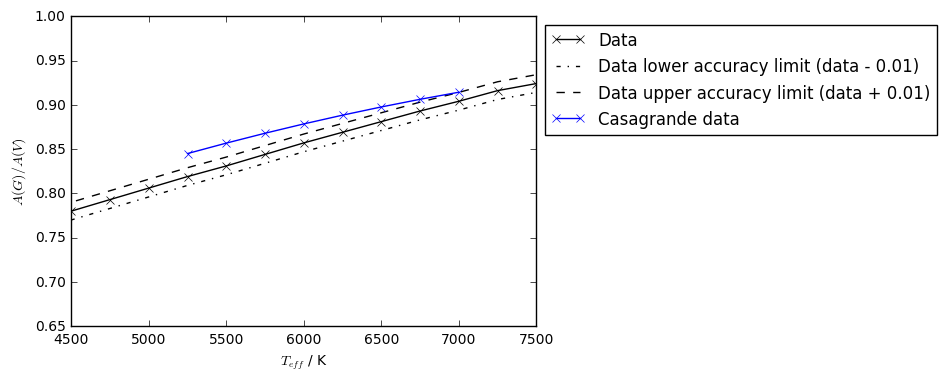


    Writing log(g)=2.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.000284456515716
Average fractional error for Power law of Teff, fitted = 0.00512735525587
Average fractional error for Power law + exponential function of Teff, fitted = 0.000463682917249
Writing complete for G filter


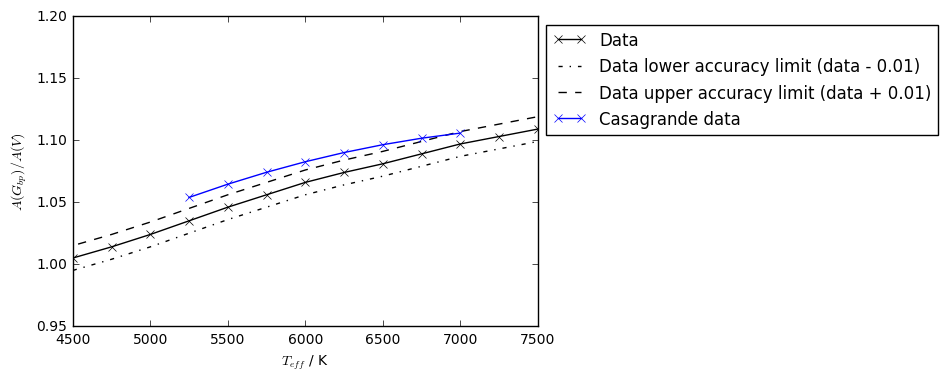


    Writing log(g)=2.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.000859484759811
Average fractional error for Power law of Teff, fitted = 0.00763047244793
Average fractional error for Power law + exponential function of Teff, fitted = 0.00154964086044
Writing complete for Gbp filter


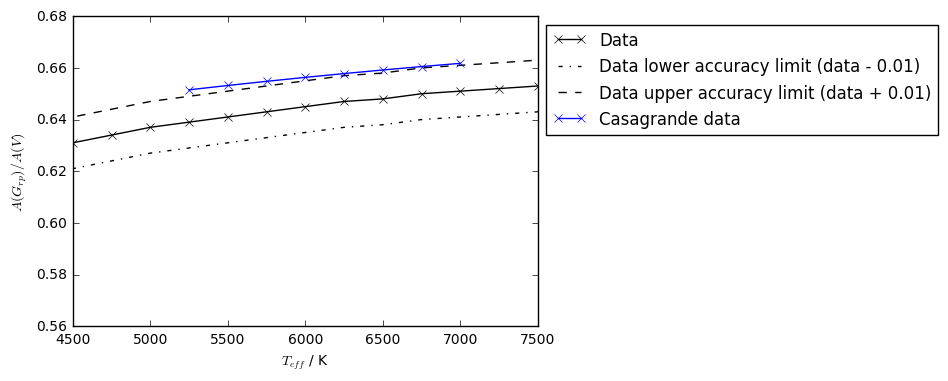


    Writing log(g)=2.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.000368906681744
Average fractional error for Power law of Teff, fitted = 0.00352220942863
Average fractional error for Power law + exponential function of Teff, fitted = 0.00035492237912
Writing complete for Grp filter

 Writing complete for log(g) = 2.0, Z = solar configuration, END OF FUNCTION WRITING!!!


'\nA_X_zs_2740_gfix\nA_X_z2_2740_gfix\n\nA_X_zs_3374_gfix\nA_X_z2_3374_gfix\n\nA_X_zs_2035_gfix\nA_X_z2_2035_gfix'

In [151]:
# GAIA FILTER PLOTTING
# filter string names
gaia_filter_str = ['G','Gbp','Grp']
# curve fitting coefficients' bounds
exp_bounds_G = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_G = ([-1.0e+05, -3., -5.], [1., 1., 5.])
plpe_bounds_G = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_Gbp = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_Gbp = ([-1.0e+03, -3., -4.], [1., 3., 4.])
plpe_bounds_Gbp = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds_Grp = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_Grp = ([-1.0e+05, -4., -6.], [1., 4., 6.])
plpe_bounds_Grp = ([-1.0e+02, -1., -5., -3.], [1., 1., 5., 3.])

exp_bounds = [exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
plpe_bounds = [plpe_bounds_G,plpe_bounds_Gbp,plpe_bounds_Grp]

#print exp_bounds
#print pow_bounds
#print plpe_bounds

# call function to general results

#metal_choice = 'sol_100'
#combined_list_coef_cov = filter_curve_fit(A_X_zs_gfix,A_X_z2_gfix,'5.0','solar',gaia_filter_str) # Leave key at '5.0'!!!
#print 'List of lists of arrays, length ',len(combined_list_coef_cov),'\n\n'
#filter_curve_plot_write(A_X_zs_gfix,A_X_z2_gfix,combined_list_coef_cov,'2.0','solar','',gaia_filter_str,'gaia_spectra','gaia_graphs','y','n',4500,7500)


In [51]:
#print combined_list_all[1]

[array([[  2.79338034e-04,   7.70976187e-08,   6.76584212e-06],
       [  7.70976187e-08,   2.57620527e-11,   3.87030584e-09],
       [  6.76584212e-06,   3.87030584e-09,   1.79492898e-06]]), array([[  2.07691944e-04,   8.88355531e-08,   8.04348948e-06],
       [  8.88355531e-08,   5.13881156e-11,   9.76299771e-09],
       [  8.04348948e-06,   9.76299771e-09,   4.84155446e-06]]), array([[  1.49136285e-05,   2.10909954e-08,   3.38301239e-07],
       [  2.10909954e-08,   3.56808576e-11,   9.52798945e-10],
       [  3.38301239e-07,   9.52798945e-10,   7.96362536e-08]])]


In [4]:
# N.B.: using cgs unit
print 'Hubble data read'
print '\n'

with open ("HubWFC/H_OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_hub_data = data_read_gaia(Av0zs)

with open ("HubWFC/H_OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_hub_data = data_read_gaia(Av1zs)

with open ("HubWFC/H_OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_hub_data = data_read_gaia(Av0z2)

with open ("HubWFC/H_OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_hub_data = data_read_gaia(Av1z2)

# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'
# dictionaries
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_hub_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_hub_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_hub_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_hub_data,2)

""""""
print '****Separating data into arrays by Teff values****'
Av0zs_Teff_fix,Av0zs_Teff_vals = grid_vals_dict(Av0zs_hub_data,1)
Av1zs_Teff_fix,Av1zs_Teff_vals = grid_vals_dict(Av1zs_hub_data,1)
Av0z2_Teff_fix,Av0z2_Teff_vals = grid_vals_dict(Av0z2_hub_data,1)
Av1z2_Teff_fix,Av1z2_Teff_vals = grid_vals_dict(Av1z2_hub_data,1)

Ahub_zs_Teff_fix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
Ahub_z2_Teff_fix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)

print '****Finished arrays****'

A_X_zs_gfix = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
A_X_z2_gfix = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)

Ahub_zs = A_X_zs_gfix
Ahub_z2 = A_X_z2_gfix

comb_dict_zs = comb_hub_gaia_dict(Ahub_zs,Agaia_zs)
comb_dict_z2 = comb_hub_gaia_dict(Ahub_z2,Agaia_z2)

# combined dictionary of arrays at fixed Teff
comb_dict_Teff_zs = comb_hub_gaia_dict(Ahub_zs_Teff_fix,Agaia_zs_Teff_fix)
comb_dict_Teff_z2 = comb_hub_gaia_dict(Ahub_z2_Teff_fix,Agaia_z2_Teff_fix)

# write out array of combined Hubble & Gaia data
#with open('AHub_vals_solar_gfix','w') as f:
#    for key in A_X_zs_gfix:
#        f.write('log(g) = ' + key + ', Z=Zsol')
#        f.write(A_X_zs_gfix[key])
        
        
print type(A_X_z2_gfix)
print type(A_X_z2_gfix['0.0'])
print comb_dict_zs['0.0'].shape
print len(comb_dict_zs)

print comb_dict_Teff_zs['5000.0'].shape
print len(comb_dict_Teff_zs)

var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$']

# 'log($T_{eff}$ / K)'

# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'
# dictionaries
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)
#print Av0z2_logg_fix['5.0']
#print A_X_z2_gfix['0.0'].shape
#print (A_X_z2_gfix['0.0'])[0,:].shape

# filter string names
hub_filter_str = ['f218w','f225w','f275w','f300x','f336w','f390w','f438w','f475w','f555w','f606w','f625w','f775w','f814w']
gaia_filter_str = ['G','Gbp','Grp']
comb_filter_str = hub_filter_str + gaia_filter_str

var_names_comb = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$']

comb_dict_zs_4500K = Teff_cutoff_fix_logg_dict(comb_dict_zs,4500.0)
comb_dict_z2_4500K = Teff_cutoff_fix_logg_dict(comb_dict_z2,4500.0)

for key in sorted(comb_dict_z2_4500K.iterkeys()):
    print comb_dict_z2_4500K[key].shape
print 'Variable data arrays organized'

Hubble data read



    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 15L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 15L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 15L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 15L)
****Creating arrays****
****Separating data into arrays by log(g) values****
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column  2  values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
****Separating data into arrays by Teff values****
Table column  1  values list:  [3500.0, 3750.0, 4000.0, 4250.0, 4500.0, 4750.0, 5000.0, 5250.0, 5

In [5]:
# HUBBLE FILTER PLOTTING

#print comb_filter_str
""""""
# curve fitting coefficients' bounds
exp_bounds_f218w = ([-100., -2., -5.], [1., 2., 5.])
pow_bounds_f218w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f218w = ([-1.0e+03, -2., -5., -1.0e+01, -1.], [1., 2., 5., 1., 1.])

exp_bounds_f225w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f225w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f225w = ([-1.0e+03, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1., 3.])

exp_bounds_f275w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f275w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f275w = ([-1.0e+02, -4., -5., -1.0e+01, -5.], [1., 4., 5., 1., 5.])

exp_bounds_f300x = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f300x = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f300x = ([-1.0e+03, -2., -3., -1.0e+01, -3.], [1., 2., 3., 1., 3.])

exp_bounds_f336w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f336w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f336w = ([-1.0e+03, -3., -3., -1.0e+01, -3.], [1., 3., 3., 1., 3.])

exp_bounds_f390w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f390w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f390w = ([-1.0e+03, -1., -5., -1.0e+01, -4.], [1., 1., 5., 1., 4.])

exp_bounds_f438w = ([-100., -1., -3.], [1., 1., 3.])
pow_bounds_f438w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f438w = ([-1.0e+03, -1., -5., -1.0e+01, -2.], [1., 1., 5., 1.0e+01, 2.])

exp_bounds_f475w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f475w = ([-1.0e+05, -2., -5.], [1., 2., 5.])
plpe_bounds_f475w = ([-1.0e+02, -1., -5., -1.0e+01, -5.], [1., 1., 5., 1., 5.])

exp_bounds_f555w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f555w = ([-1.0e+05, -3., -5.], [1., 1., 5.])
plpe_bounds_f555w = ([-1.0e+02, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1.0e+01, 3.])

exp_bounds_f606w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f606w = ([-1.0e+05, -2., -5.], [1., 2., 5.])
plpe_bounds_f606w = ([-1.0e+03, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1.0e+01, 3.])

exp_bounds_f625w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f625w = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_f625w = ([-1.0e+03, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1.0e+01, 3.])

exp_bounds_f775w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f775w = ([-1.0e+05, -3., -5.], [1, 3., 5.])
plpe_bounds_f775w = ([-1.0e+03, -1., -5., -1.0e+01, -5.], [1., 1., 5., 1.0e+01, 5.])

exp_bounds_f814w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f814w = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_f814w = ([-1.0e+02, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1.0e+01, 3.])

exp_bounds_G = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_G = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_G = ([-1.0e+02, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1., 3.])

exp_bounds_Gbp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Gbp = ([-1.0e+04, -3., -5.], [1., 3., 5.])
plpe_bounds_Gbp = ([-1.0e+02, -1., -3., -1.0e+01, -3.], [1., 1., 3., 1., 3.])

exp_bounds_Grp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Grp = ([-1.0e+07, -3., -5.], [1., 3., 5.])
plpe_bounds_Grp = ([-1.0e+02, -1., -5., -1.0e+01, -3.], [1., 1., 5., 1., 3.])

# make array of bounds
exp_bounds = [exp_bounds_f218w,exp_bounds_f225w,exp_bounds_f275w,exp_bounds_f300x,exp_bounds_f336w,exp_bounds_f390w,exp_bounds_f438w,exp_bounds_f475w,exp_bounds_f555w,exp_bounds_f606w,exp_bounds_f625w,exp_bounds_f775w,exp_bounds_f814w,exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_f218w,pow_bounds_f225w,pow_bounds_f275w,pow_bounds_f300x,pow_bounds_f336w,pow_bounds_f390w,pow_bounds_f438w,pow_bounds_f475w,pow_bounds_f555w,pow_bounds_f606w,pow_bounds_f625w,pow_bounds_f775w,pow_bounds_f814w,pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
plpe_bounds = [plpe_bounds_f218w,plpe_bounds_f225w,plpe_bounds_f275w,plpe_bounds_f300x,plpe_bounds_f336w,plpe_bounds_f390w,plpe_bounds_f438w,plpe_bounds_f475w,plpe_bounds_f555w,plpe_bounds_f606w,plpe_bounds_f625w,plpe_bounds_f775w,plpe_bounds_f814w,plpe_bounds_G,plpe_bounds_Gbp,plpe_bounds_Grp]

# produce fitting results - leave key at '5.0'!!!
print 'SOLAR METALLICITY FITTING'
combined_list_coef_cov_zs = filter_curve_fit(comb_dict_zs,comb_dict_z2,'5.0','solar',comb_filter_str)
print 'List of lists of arrays, length ',len(combined_list_coef_cov_zs)
print '\n'
#print '(SOLAR METALLICITY)/100 FITTING'
#combined_list_coef_cov_z2 = filter_curve_fit(comb_dict_zs,comb_dict_z2,'5.0','sol_100',comb_filter_str)
#print 'List of lists of arrays, length ',len(combined_list_coef_cov_z2),'\n\n'


SOLAR METALLICITY FITTING
Calculating coefficients & covariance matrices for f218w filter
Exponential fit coefficients: 
[ -1.81038390e+01  -5.93941663e-04   2.95434541e+00]
Covariance matrix: 
[[  8.61213585e+00   1.12835295e-04   1.99756253e-02]
 [  1.12835295e-04   1.53973476e-09   3.28322964e-07]
 [  1.99756253e-02   3.28322964e-07   3.45067194e-04]]
Teff^(n) fit coefficients: 
[ -1.00000000e+08  -2.16261281e+00   3.03686613e+00]
Covariance matrix: 
[[  2.47218962e+16   2.97950406e+07   3.54657448e+06]
 [  2.97950406e+07   3.59386177e-02   4.35048439e-03]
 [  3.54657448e+06   4.35048439e-03   1.11218251e-03]]
Teff^(n) + exponential fit coefficients: 
[ -1.69422575e+01  -5.66735310e-04   2.60453227e+00   9.99995619e-01
  -1.04937919e-01]
Covariance matrix: 
[[  1.04613149e+01   2.19610912e-04   2.09394152e+01   4.88879958e+00
   -6.47112617e+00]
 [  2.19610912e-04   6.33776783e-09   1.09139480e-03   2.00996026e-04
   -3.32107060e-04]
 [  2.09394152e+01   1.09139480e-03   3.13597032e

C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:249: RuntimeWarning: overflow encountered in exp
C:\Users\User\Anaconda2\lib\site-packages\ipykernel\__main__.py:249: RuntimeWarning: overflow encountered in multiply


Calculating coefficients & covariance matrices for f275w filter
Exponential fit coefficients: 
[ -6.65645300e+00  -7.16394636e-04   2.05019946e+00]
Covariance matrix: 
[[  6.06805922e-01   2.23417439e-05   6.67384294e-04]
 [  2.23417439e-05   8.47197049e-10   2.96732999e-08]
 [  6.67384294e-04   2.96732999e-08   6.15303753e-06]]
Teff^(n) fit coefficients: 
[ -1.00000000e+08  -2.33870373e+00   2.07134071e+00]
Covariance matrix: 
[[  6.24945156e+15   7.53570777e+06   1.78694401e+05]
 [  7.53570777e+06   9.09326363e-03   2.19146765e-04]
 [  1.78694401e+05   2.19146765e-04   1.20588866e-05]]
Teff^(n) + exponential fit coefficients: 
[ -6.65631461e+00  -7.16389396e-04   2.05019964e+00  -1.35732322e+00
  -3.25986583e+00]
Covariance matrix: 
[[  6.23865222e-01   2.29702939e-05   6.86167981e-04   0.00000000e+00
    0.00000000e+00]
 [  2.29702939e-05   8.71049026e-10   3.05091012e-08   0.00000000e+00
    0.00000000e+00]
 [  6.86167981e-04   3.05091012e-08   6.32638001e-06   0.00000000e+00
    0

In [ ]:
# Round 2 for stuff that doesn't conform to power-law profile for Teff
# snowball cell

In [6]:
# snowballing cell

# spline interpolation

# curve fitting coefficients' bounds
exp_bounds_f218w = ([-1.0e+03, -1., -5.], [1., 1., 5.])
pow_bounds_f218w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f218w = ([-1.0e+02, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

exp_bounds_f225w = ([-1.0e+03, -1., -5.], [1., 1., 5.])
pow_bounds_f225w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f225w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f275w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f275w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f275w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f300x = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f300x = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f300x = ([-1.0e+03, -1.0e-01, -6., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f336w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f336w = ([-1.0e+08, -3., -5.], [1., 3., 5.])
plpe_bounds_f336w = ([-1.0e+01, -1.0e-01, -6., -1.0e-01, -1.], [1., 0., 6., 1.0e-01, 1.])

exp_bounds_f390w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f390w = ([-1.0e+03, -1.0e-01, 1.], [1., 1.0e-02, 3.])
plpe_bounds_f390w = ([-1.0e+00, -1.0e-01, -3., -1.0e-01, -1.0e-01], [1., 0., 3., 1.0e-01, 1.0e-01])

exp_bounds_f438w = ([-100., -1., -3.], [1., 1., 3.])
pow_bounds_f438w = ([-1.0e+05, -2., -5.], [1., 2., 5.])
plpe_bounds_f438w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f475w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f475w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f475w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 1.0e-01, 5., 1.0e-01, 1.])

exp_bounds_f555w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f555w = ([-1.0e+06, -3., -5.], [1., 1., 5.])
plpe_bounds_f555w = ([-1.0e+01, -1.0e-01, -5., -1.0e-01, -1.], [1., 0., 5., 1.0e-01, 1.])

exp_bounds_f606w = ([-100., -1., -5.], [0., 1., 5.])
pow_bounds_f606w = ([-1.0e+06, -2., -5.], [1., 2., 5.])
plpe_bounds_f606w = ([-1.0e+01, -1.0e-01, -6., -1.0e-01, -1.], [1., 0., 6., 1.0e-01, 1.])

exp_bounds_f625w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f625w = ([-1.0e+06, -3., -5.], [1., 3., 5.])
plpe_bounds_f625w = ([-1.0e+01, -1.0e-01, -6., -1.0e-01, -1.], [1., 0., 6., 1.0e-01, 1.])

exp_bounds_f775w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f775w = ([-1.0e+05, -3., -5.], [1, 3., 5.])
plpe_bounds_f775w = ([-1.0e+01, -1.0e-01, -6., -1.0e-01, -1.], [1., 1.0e-01, 6., 1.0e-01, 1.])

exp_bounds_f814w = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_f814w = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_f814w = ([-1.0e+01, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

exp_bounds_G = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_G = ([-1.0e+05, -3., -5.], [1., 3., 5.])
plpe_bounds_G = ([-1.0e+01, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

exp_bounds_Gbp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Gbp = ([-1.0e+04, -3., -5.], [1., 3., 5.])
plpe_bounds_Gbp = ([-1.0e+01, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

exp_bounds_Grp = ([-100., -1., -5.], [1., 1., 5.])
pow_bounds_Grp = ([-1.0e+07, -3., -5.], [1., 3., 5.])
plpe_bounds_Grp = ([-1.0e+01, -1.0e-01, -5., -1., -1.], [1., 0., 5., 1., 1.])

# make array of bounds
exp_bounds = [exp_bounds_f218w,exp_bounds_f225w,exp_bounds_f275w,exp_bounds_f300x,exp_bounds_f336w,exp_bounds_f390w,exp_bounds_f438w,exp_bounds_f475w,exp_bounds_f555w,exp_bounds_f606w,exp_bounds_f625w,exp_bounds_f775w,exp_bounds_f814w,exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_f218w,pow_bounds_f225w,pow_bounds_f275w,pow_bounds_f300x,pow_bounds_f336w,pow_bounds_f390w,pow_bounds_f438w,pow_bounds_f475w,pow_bounds_f555w,pow_bounds_f606w,pow_bounds_f625w,pow_bounds_f775w,pow_bounds_f814w,pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
plpe_bounds = [plpe_bounds_f218w,plpe_bounds_f225w,plpe_bounds_f275w,plpe_bounds_f300x,plpe_bounds_f336w,plpe_bounds_f390w,plpe_bounds_f438w,plpe_bounds_f475w,plpe_bounds_f555w,plpe_bounds_f606w,plpe_bounds_f625w,plpe_bounds_f775w,plpe_bounds_f814w,plpe_bounds_G,plpe_bounds_Gbp,plpe_bounds_Grp]

# produce fitting results - leave key at '5.0'!!!
print 'SOLAR METALLICITY FITTING'
combined_list_coef_cov_zs_4500K = filter_curve_fit(comb_dict_zs_4500K,comb_dict_z2_4500K,'5.0','solar',comb_filter_str)
print 'List of lists of arrays, length ',len(combined_list_coef_cov_zs_4500K)
#print '(SOLAR METALLICITY)/100 FITTING'
#combined_list_coef_cov_z2_4500K = filter_curve_fit(comb_dict_zs_4500K,comb_dict_z2_4500K,'5.0','sol_100',comb_filter_str)
#print 'List of lists of arrays, length ',len(combined_list_coef_cov_z2_4500K),'\n\n'
#print '\n'

""""""

SOLAR METALLICITY FITTING
Calculating coefficients & covariance matrices for f218w filter
Exponential fit coefficients: 
[ -2.32428259e+02  -1.07634845e-03   2.93338391e+00]
Covariance matrix: 
[[  2.30944564e+03   2.05261468e-03   1.03582938e-01]
 [  2.05261468e-03   1.84082262e-09   1.01493353e-07]
 [  1.03582938e-01   1.01493353e-07   4.84194727e-05]]
Teff^(n) fit coefficients: 
[ -1.00000000e+08  -2.16846837e+00   3.03079547e+00]
Covariance matrix: 
[[  7.82867661e+16   9.17606751e+07   6.93045811e+06]
 [  9.17606751e+07   1.07628655e-01   8.26037789e-03]
 [  6.93045811e+06   8.26037789e-03   1.26403014e-03]]
Teff^(n) + exponential fit coefficients: 
[ -1.00000000e+02  -8.95880100e-04   2.79183763e+00   1.00000000e+00
  -1.92382308e-01]
Covariance matrix: 
[[  8.50762308e+02   2.03278041e-03   3.48060929e+01   2.26609596e+02
   -4.66006194e+01]
 [  2.03278041e-03   4.97021840e-09   9.64170621e-05   6.23624750e-04
   -1.28692534e-04]
 [  3.48060929e+01   9.64170621e-05   3.70193850e

''


    Writing log(g)=5.0, Z = solar model for f218w filter
Average fractional error for Exponential function of Teff, fitted = 0.00878879567624
Average fractional error for Power law of Teff, fitted = 1.3831642575
Average fractional error for Power law + exponential function of Teff, fitted = 32.7945448525

    Writing log(g)=5.0, Z = solar model for f225w filter
Average fractional error for Exponential function of Teff, fitted = 0.00239641299469
Average fractional error for Power law of Teff, fitted = 0.808095638047
Average fractional error for Power law + exponential function of Teff, fitted = 7935.31734713

    Writing log(g)=5.0, Z = solar model for f275w filter
Average fractional error for Exponential function of Teff, fitted = 0.00105540352195
Average fractional error for Power law of Teff, fitted = 0.0292078769595
Average fractional error for Power law + exponential function of Teff, fitted = 29.7444354869

    Writing log(g)=5.0, Z = solar model for f300x filter
Average fraction

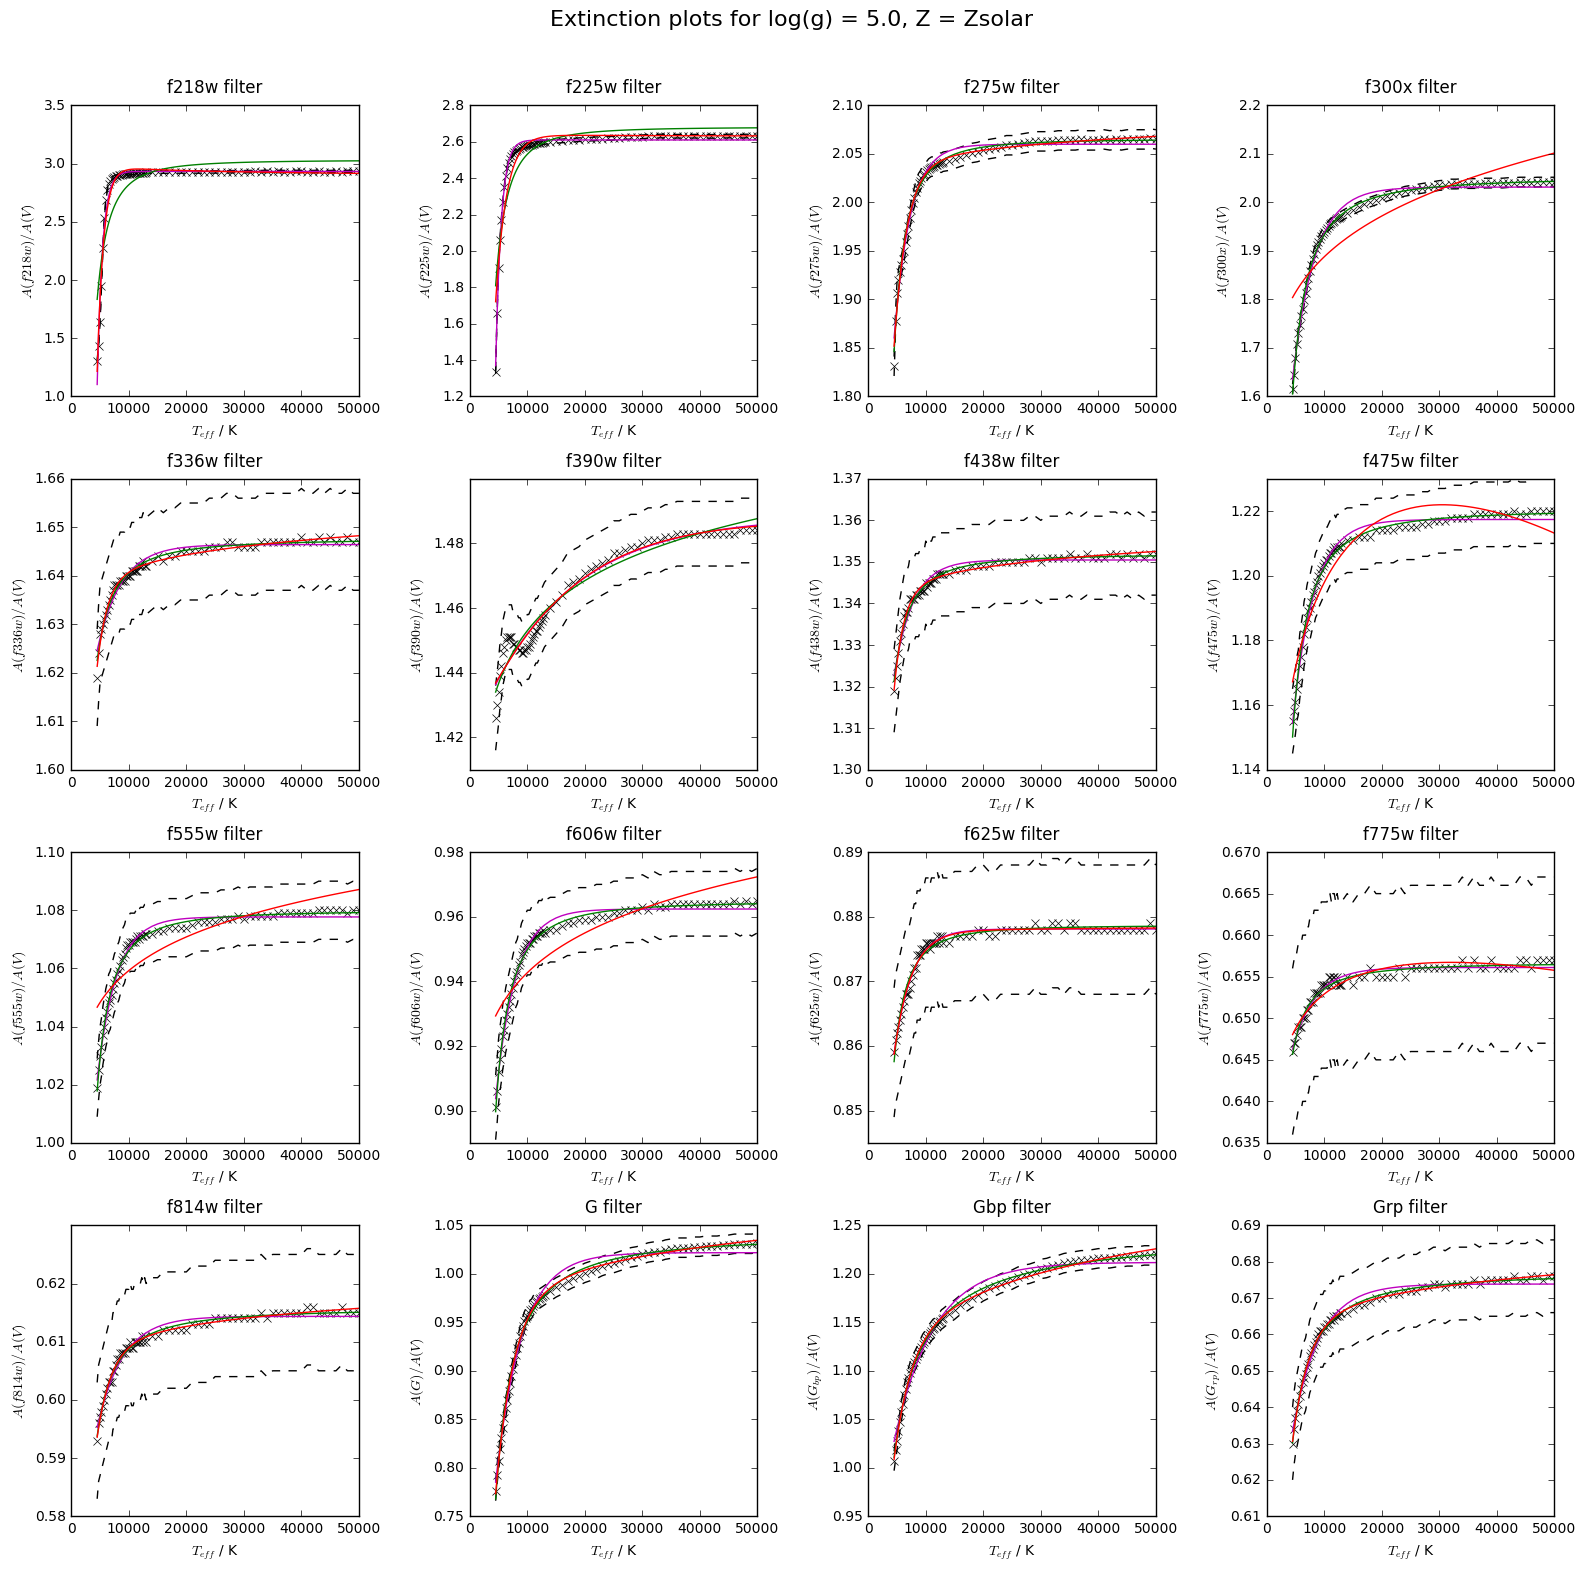


 Writing complete for log(g) = 5.0, Z = solar configuration, END OF FUNCTION WRITING!!!


In [94]:
# If finished fitting (i.e. log(g) not equal to 5.0), DON'T run previous cell!!!

# Test solar metallicity fit on BOTH metallicity scenarios
filter_curve_plot_write(comb_dict_zs_4500K,comb_dict_z2_4500K,combined_list_coef_cov_zs_4500K,'5.0','solar','4500K',comb_filter_str,'HubWFC','Hub_graphs','n','y')
#filter_curve_plot_write(comb_dict_zs_4500K,comb_dict_z2_4500K,combined_list_coef_cov_z2_4500K,'5.0','solar','4500K',comb_filter_str,'HubWFC','Hub_graphs','n','y',8000,20000)
#,4400,6000

In [1]:
# Create coefficient summary text file for power law
# filename options:
# IN: metallicity: solar, sol_100
# OUT: metallicity: solar, solar/100
"""
print len(comb_filter_str)
make_coeffs_summary('HubWFC/','Teff_AHub_gaia_gen_fit_logg=5.0_sol_100_numbers.txt','coeffs_hub_gaia_power.txt',comb_filter_str,'5.0','solar/100','a')
"""

# low-Teff: log(g) affects A(filter)/A(V), i.e. A(Teff) becomes A(Teff,log(g))
# -> find law for log(g) effects
# N.B.: log(g) = consts. x (M(R*)/(R*)^2)
# Linear? Girardi et al. (2008) use giant Teff law: Teff(log(g)) = 3250 + 500log(g)
# For my values of log(g) (= 0 to 5), this gives a range of (3250 <= Teff <= 5750)
# Take our working definition of 0.01 'error' as a limit on log(g) effects

#print ' \t Full-Data Dictionary'
#low_logg_law_trunc(comb_dict_zs,0.01)
#print '\n \t Teff >= 4500K Data Dictionary'
#low_logg_law_trunc(comb_dict_zs_4500K,0.01)

"\nprint len(comb_filter_str)\nmake_coeffs_summary('HubWFC/','Teff_AHub_gaia_gen_fit_logg=5.0_sol_100_numbers.txt','coeffs_hub_gaia_power.txt',comb_filter_str,'5.0','solar/100','a')\n"

In [7]:
# Combining the two effects
# Teff-only coefficients lists
exp_Teff_coef_4500K_logg_5 = combined_list_coef_cov_zs_4500K[0]
exp_Teff_covar_4500K_logg_5 = combined_list_coef_cov_zs_4500K[1]
pow_Teff_coef_4500K_logg_5 = combined_list_coef_cov_zs_4500K[2]
pow_Teff_covar_4500K_logg_5 = combined_list_coef_cov_zs_4500K[3]
plpe_Teff_coef_4500K_logg_5 = combined_list_coef_cov_zs_4500K[4]
plpe_Teff_covar_4500K_logg_5 = combined_list_coef_cov_zs_4500K[5]

# Following line gives: number of filters, number of coeffs for function (apply to each filter)
# Total number of Teff-only curves produced earlier = 16x3 = 48 -> 48 sets of coefficients, 48 covariance matrices
print len(exp_Teff_coef_4500K_logg_5),len(exp_Teff_coef_4500K_logg_5[0])

# exp_func(A_X_chosen[:,0],*exp_fit_A_logg5)
# single_poly(A_X_chosen[:,0],*pow_fit_A_logg5)
# full_pow_plus_exp_func(A_X_chosen[:,0],*plpe_fit_A_logg5)
# add Teff, log(g) variations together using iterations

def combined_effects_grid_sync(logg_fixed_dict,Teff_fixed_coeffs_dict):
    """Example of output combined effect
    pow_Teff_only = single_poly(key_data[:,0], *pow_Teff_coef_4500K_logg_5[i-2])
    logg_diff_i = quad_func(float(key), *logg_coeffs_stored[i-2])
    final_pow_combo = pow_Teff_only + logg_diff_i"""
    # plot-format data dictionary
    for logg_key in logg_fixed_dict:
        logg_fixed_data = logg_fixed_dict[logg_key]
        pow_Teff_only = single_poly(logg_fixed_data[:,0], *pow_Teff_coef_4500K_logg_5[i-2])
        # coefficients dictionary - only 1 per filter (each dictionary contains only 1 item)!
        for Teff_key in Teff_fixed_coeffs_dict:
            # match Teff values
            if (key[0] == '0'):
                Teff_tidy_key = Teff_key[1:]
            else:
                Teff_tidy_key = Teff_key
            for i in (logg_fixed_dict[logg_key])[:,0]:
                if (float(Teff_tidy_key) == i):
            

def combined_effects_plot_write(logg_fixed_dict,teff_fixed_dict,folder,graph_fold,filter_str):
    # First iteration for-loop: only BETWEEN log(g) values!
    # i.e. only applies to Teff-varying dictionaries! There should be 11 dictionaries, output graph files, etc.
    for key in logg_fixed_dict:
        
        key_data = logg_fixed_dict[key]
        # set up plot output file
        plot_dir_str_i = None
        data_dir_str_i = None
        fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
        axs = axs.ravel()
        # Write out to new file: first 'with' statement empties the file to be written into later
        data_dir_str_i = folder + '/Teff_AHub_gaia_gen_fit_logg=' + key + '_' + metal + '_' + extras + '_numbers_modded.txt'
        
        if (key == '5.0'):
            with open (data_dir_str_i,'w') as f:
                f.close()
                
        # iterate over filters (need to do so for BOTH Teff,log(g)!)
        for i in range(2,len((logg_fixed_dict['5.0'])[0,:])):
            # log(g) modifying values
            if (key == '5.0'):
                logg_diff_i = 0.0
            else:
                logg_diff_i = quad_func(float(key), *logg_coeffs_stored[i-2])
            # Note: '_combo' quantities are actual A ratio data -> PLOT DIRECTLY!
            # Note: '_only' quantities are actual A ratio data, but ONLY for Teff effects!
            # exponential function
            exp_Teff_only = exp_func(key_data[:,0], *exp_Teff_coef_4500K_logg_5[i-2])
            exp_Teff_list.append(exp_Teff_only)
            
            final_exp_combo = exp_Teff_only + logg_diff_i
            exp_combo_list.apppend(final_exp_combo)
            
            # power-law function
            pow_Teff_only = single_poly(key_data[:,0], *pow_Teff_coef_4500K_logg_5[i-2])
            pow_Teff_list.append(pow_Teff_only)
            
            final_pow_combo = pow_Teff_only + logg_diff_i
            pow_combo_list.append(final_pow_combo)
            
            # (exponential + power-law) function
            plpe_Teff_only = full_pow_plus_exp_func(key_data[:,0], *plpe_Teff_coef_4500K_logg_5[i-2])
            plpe_Teff_list.append(plpe_Teff_only)
            
            final_plpe_combo = plpe_Teff_only + logg_diff_i
            plpe_combo_list.append(final_plpe_combo)
            """
            if (key == '5.0'):
                avg_dict = {}
                with open (data_dir_str_i,'a') as f:
                    print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model for ' + filter_str[i-2] + ' filter'
                    general_fit_number_gen_write(f,fit_types[0],exp_fit_A_logg5, covarr_A_logg5_ef,filter_str[i-2],float(key),avg_dict)
                    general_fit_number_gen_write(f,fit_types[1],pow_fit_A_logg5, covarr_A_logg5_pow,filter_str[i-2],float(key),avg_dict)
                    general_fit_number_gen_write(f,fit_types[2],plpe_fit_A_logg5, covarr_A_logg5_plpe,filter_str[i-2],float(key),avg_dict)

                    # write results of comparison of averages
                    sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
                    f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   ' + '\n')
                    for j in sorted_avg:
                        f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
                    f.close()
            """        
            print 'Writing complete for ' + filter_str[i-2] + ' filter'
    
            
            # Teff plots
            # set labels in each figure
            axs[i-2].set_xlabel(var_names_comb[0])
            axs[i-2].set_ylabel(var_names_comb[i])
            # plot data + window in each figure
            axs[i-2].plot(key_data[:,0],key_data[:,i],'k',marker='x',linestyle='',label='Data')
            axs[i-2].plot(key_data[:,0],(key_data[:,i] - 0.01),'k',linestyle='--',label='Data lower accuracy limit (data - 0.01)')
            axs[i-2].plot(key_data[:,0],(key_data[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
            # plot fits in each figure
            axs[i-2].plot(key_data[:,0],exp_combo_list[i],'m',label=fit_types[0])
            axs[i-2].plot(key_data[:,0],pow_combo_list[i],'g',label=fit_types[1])
            axs[i-2].plot(key_data[:,0],plpe_combo_list[i],'r',label=fit_types[2])
        print  '\n Writing complete for log(g)-corrected Teff functions for log(g) = ' + key + 'Z = ' + metal
    print '\n Writing complete for log(g)-corrected Teff functions, Z = ' + metal + ' configuration, END OF FUNCTION WRITING!!!'
    
""""""    

16 3


"exp_func(A_X_chosen[:,0],*exp_fit_A_logg5)\n# add Teff, log(g) variations together using iterations\ndef combined_effects_plot_write(logg_fixed_dict):\n    \n    # First iteration for-loop: ONLY between log(g) values!\n    for key in comb_dict_zs_4500K:\n        # iterate over filters\n        for i in range(2,len((comb_dict_zs_4500K['5.0'])[0,:])):\n            # log(g) filters\n            if (key == '5.0'):\n                logg_diff = 0.0\n            else:\n                logg_diff = quad_func(float(key),*logg_coeffs_stored[i-2])\n            \n"

Function output dictionary
76
High-Teff cutoff for log(g) effect modelling for fixed-Teff dictionaries
3500.0
3750.0
4000.0
4250.0
4500.0
4500.0
4750.0
4750.0
5000.0
5000.0
5250.0
5250.0
5500.0
5500.0
5750.0
5750.0
6000.0
6000.0
6250.0
6250.0
6500.0
6500.0
6750.0
6750.0
7000.0
7000.0
7250.0
7250.0
7500.0
7500.0
7750.0
7750.0
8000.0
8000.0
8250.0
8250.0
8500.0
8500.0
8750.0
8750.0
9000.0
9000.0
9250.0
9250.0
9500.0
9500.0
9750.0
9750.0
10000.0
10000.0
10250.0
10250.0
10500.0
10500.0
10750.0
10750.0
11000.0
11000.0
11250.0
11250.0
11500.0
11500.0
11750.0
11750.0
12000.0
12000.0
12250.0
12250.0
12500.0
12500.0
12750.0
12750.0
13000.0
13000.0
14000.0
14000.0
15000.0
15000.0
16000.0
16000.0
17000.0
17000.0
18000.0
18000.0
19000.0
19000.0
20000.0
20000.0
21000.0
22000.0
23000.0
24000.0
25000.0
26000.0
27000.0
28000.0
29000.0
30000.0
31000.0
32000.0
33000.0
34000.0
35000.0
36000.0
37000.0
38000.0
39000.0
40000.0
41000.0
42000.0
43000.0
44000.0
45000.0
46000.0
47000.0
48000.0
49000.0
50000.0
R

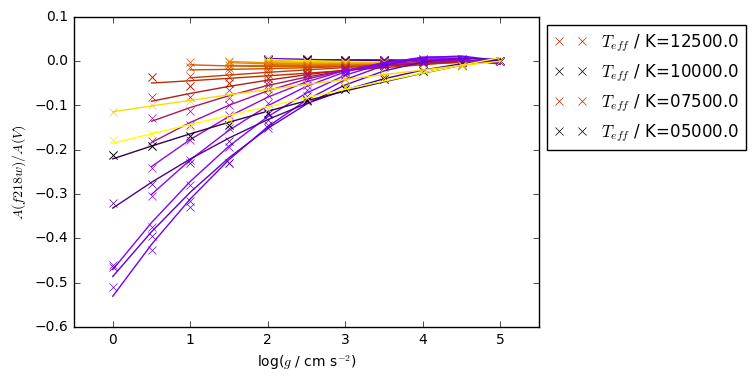

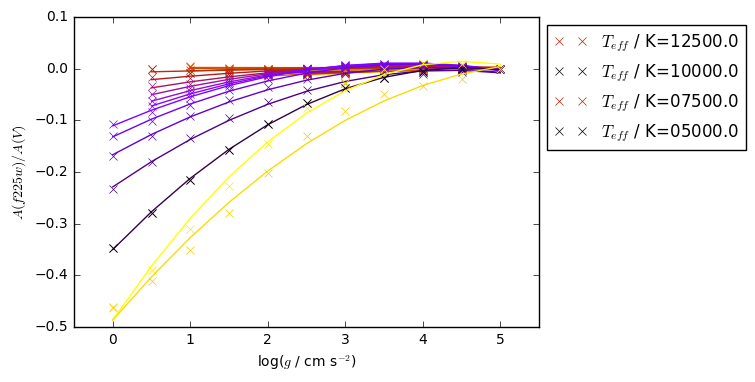

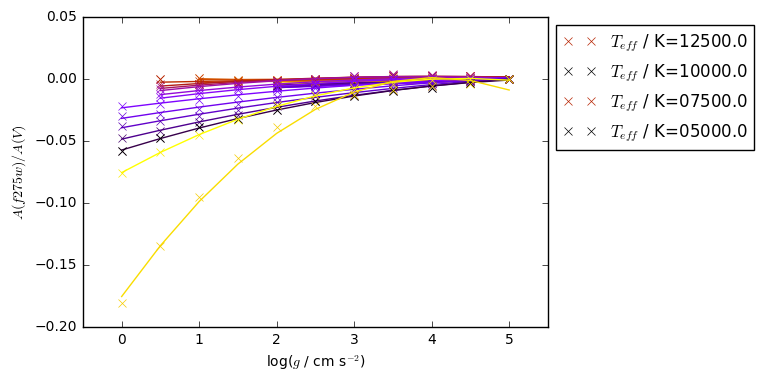

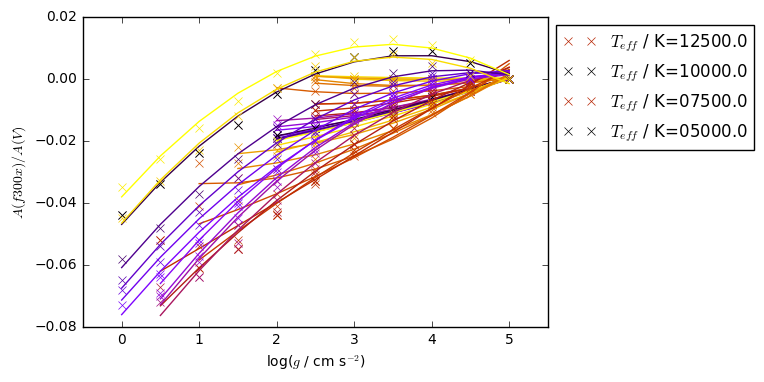

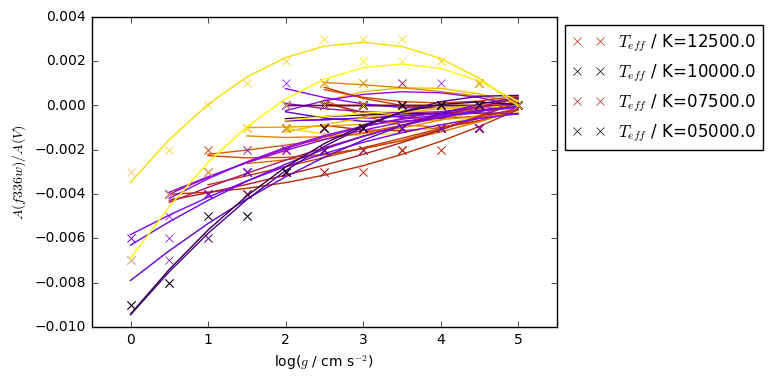

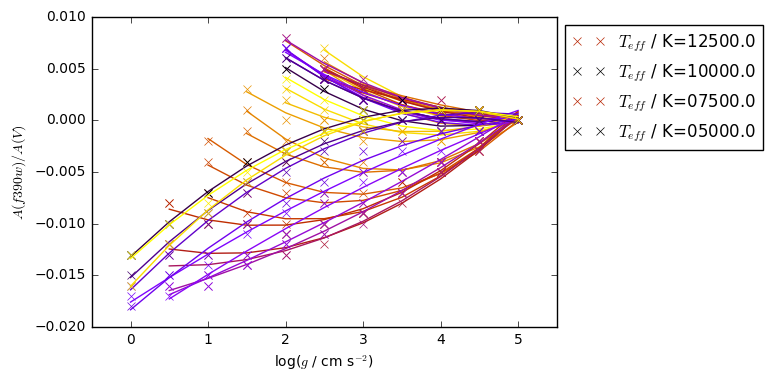

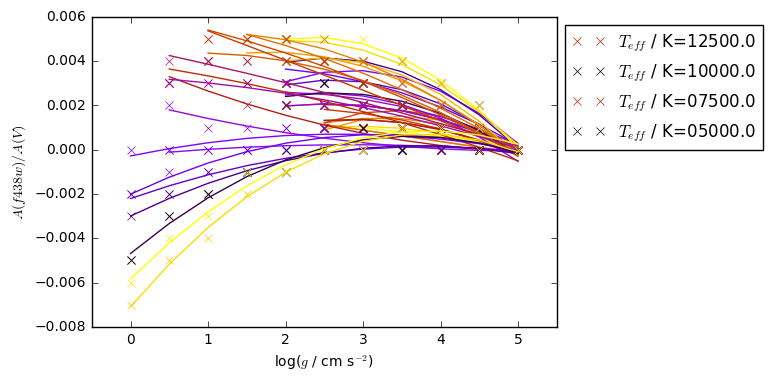

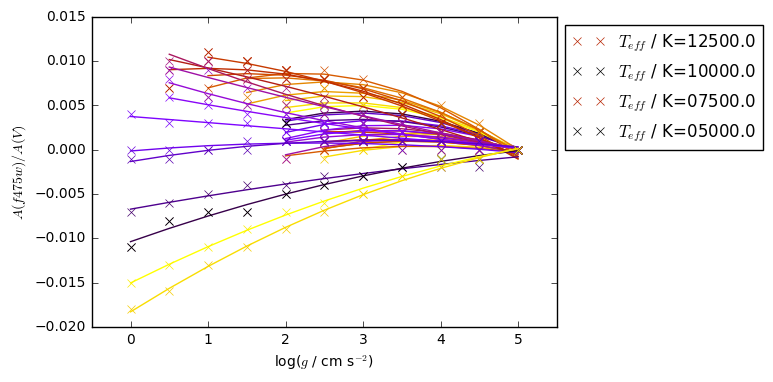

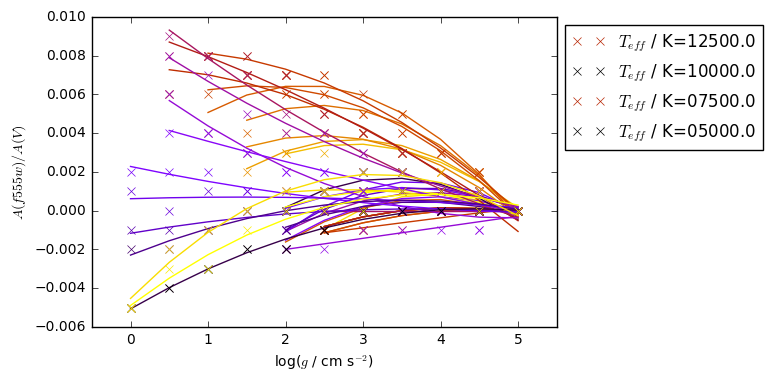

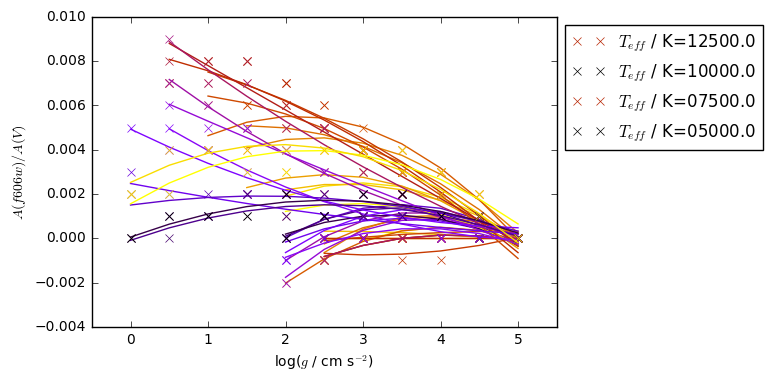

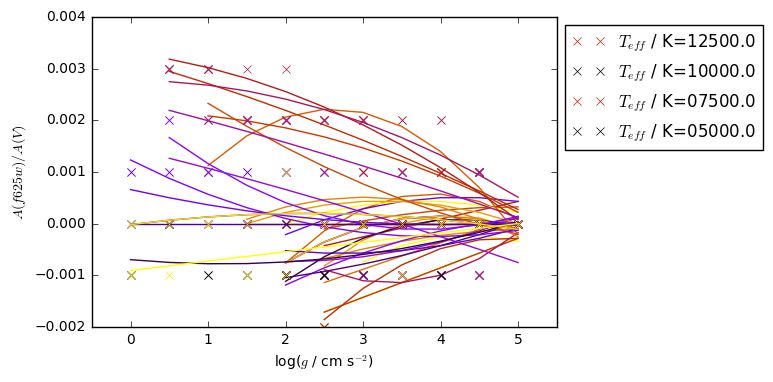

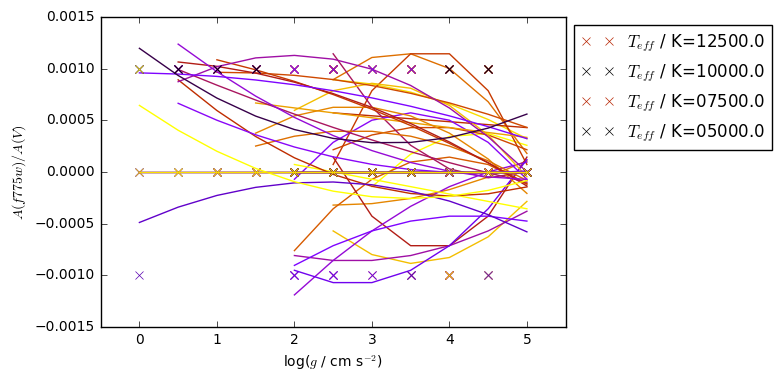

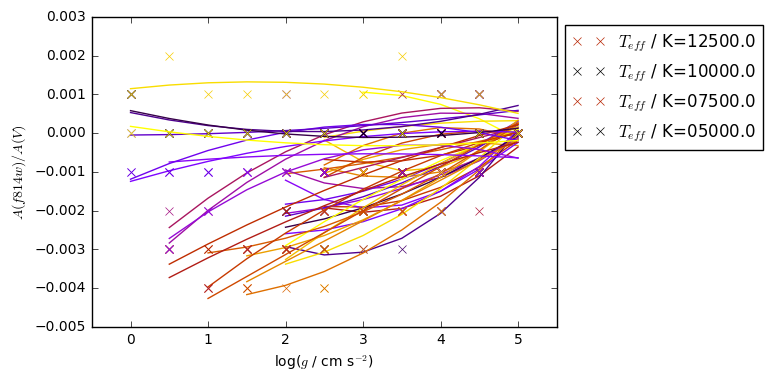

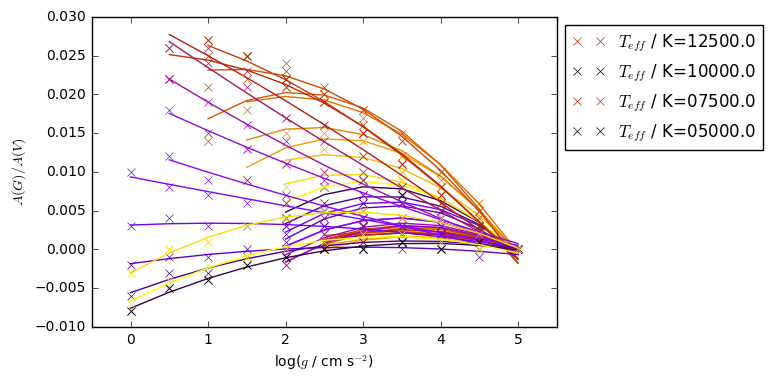

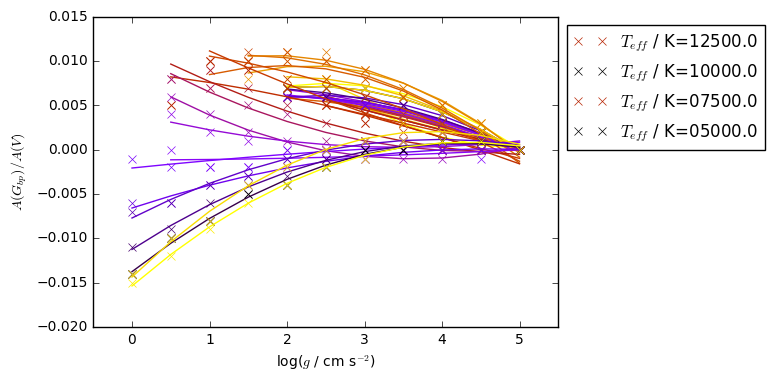

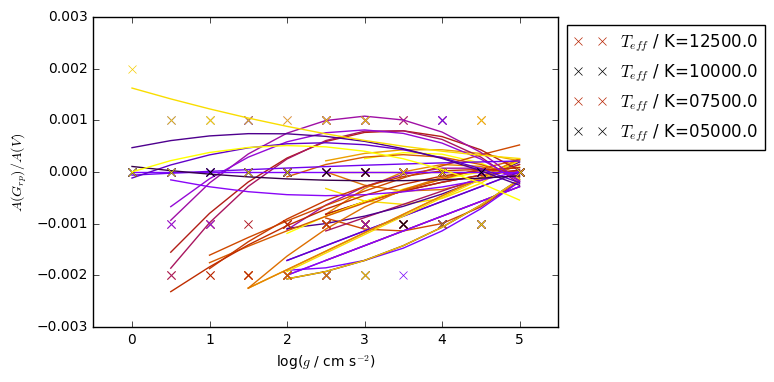

logg results storage size:
16 3


In [10]:
var_names_comb = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$']

# solar metallicity
comb_Teff_zs_sort = {}
# difference dictionary with log(g) as a reference
comb_Teff_zs_sort_diff = {}

# solar/100 metallicity
comb_Teff_z2_sort = {}
# difference dictionary with log(g) as a reference
comb_Teff_z2_sort_diff = {}

# properly ordered sorting
for old_key in comb_dict_Teff_zs:
    new_key = old_key.zfill(7)
    comb_Teff_zs_sort[new_key] = comb_dict_Teff_zs[old_key]
    comb_Teff_z2_sort[new_key] = comb_dict_Teff_z2[old_key]

#for key in sorted(comb_Teff_zs_sort.iterkeys()):
#    comb_Teff_zs_sort_diff[key] = comb_Teff_zs_sort[key]
#    comb_Teff_z2_sort_diff[key] = comb_Teff_z2_sort[key]

def diff_from_ref(input_dict):
    out_dict = {}
    for key in sorted(input_dict.iterkeys()):
        holder_arr = (input_dict[key])
        i_list = []
        for i in range(len(holder_arr[:,0])): # iterate over rows
            j_list = []
            for j in range(len(holder_arr[0,:])): # iterate over columns in row
                if (j==0 or j==1):
                    j_val = holder_arr[i,j]
                else:
                    j_val = (holder_arr[i,j] - holder_arr[-1,j])
                j_list.append(j_val)
            i_list.append(j_list)
        out_dict[key] = np.array(i_list)
    return out_dict
                
#print 'blah'
#print comb_dict_Teff_zs['45000.0']
#print comb_Teff_zs_sort['45000.0']
print 'Function output dictionary'

# dictionary of difference values from log(g) = 5.0
comb_Teff_zs_sort_diff = diff_from_ref(comb_Teff_zs_sort)

print len(comb_Teff_zs_sort_diff)
comb_Teff_zs_sort_diff_4500_20000 = Teff_cutoff_fix_Teff_dict(comb_Teff_zs_sort_diff,4500.0,20000.0)
comb_Teff_z2_sort_diff_4500_20000 = Teff_cutoff_fix_Teff_dict(comb_Teff_z2_sort_diff,4500.0,20000.0)
print len(comb_Teff_zs_sort_diff)
#print 'Dictionary size: ',len(comb_Teff_zs_sort)
#print 'Shape of following array: ',comb_Teff_zs_sort['05500.0'].shape
#print comb_Teff_zs_sort['05500.0']
""""""
with open('dict_fixed_Teff_example.txt','w') as f:#comb_Teff_zs_sort
    for key in sorted(comb_dict_Teff_zs.iterkeys()):
        if (key[0] == '0'):
            tidy_key = key[1:]
            f.write('Array for Teff = ' + tidy_key + '\n')
        else:
            f.write('Array for Teff = ' + key + '\n')
        f.write('Shape: '+ str(comb_dict_Teff_zs[key].shape) + '\n')#,' by ',str(comb_Teff_zs_sort[key].shape[1])
        f.write('Array has the following log(g) values: ')
        for i in range(len(comb_dict_Teff_zs[key][:,1])):
            f.write(str(comb_dict_Teff_zs[key][i,1]) + ' ')
        f.write('\n' + str(comb_dict_Teff_zs[key]) + '\n')
        f.write('\n')
    f.close()

with open('diff_dict_fixed_Teff_example.txt','w') as f:
    for key in sorted(comb_Teff_zs_sort_diff.iterkeys()):
        if (key[0] == '0'):
            tidy_key = key[1:]
            f.write('Array for Teff = ' + tidy_key + '\n')
        else:
            f.write('Array for Teff = ' + key + '\n')
        f.write('Shape: '+ str(comb_Teff_zs_sort_diff[key].shape) + '\n')#,' by ',str(comb_Teff_zs_sort[key].shape[1])
        f.write('Array has the following log(g) values: ')
        for i in range(len(comb_Teff_zs_sort_diff[key][:,1])):
            f.write(str(comb_Teff_zs_sort_diff[key][i,1]) + ' ')
        f.write('\n' + str(comb_Teff_zs_sort_diff[key]) + '\n')
        f.write('\n')
    f.close()

def logg_coeffs_tidyup(fit_out,input_dict,fit_func_bounds):
    coeffs_dict_key_fix_Teff = {}
    cov_dict_key_fix_Teff = {}
    with open(fit_out,'w') as f:
        f.close()
    
    x = 0
                   
    # one iterator value per Teff value 'key'
    for key in reversed(sorted(input_dict.iterkeys())):
        x += 1
        # reset lists for each Teff value
        logg_coeffs_at_1_Teff_stored = []
        logg_cov_at_1_Teff_stored = []
        
        # should give 16 iterations in this loop
        for i in range(2,len((input_dict['05000.0'])[0,:]):
            """j_stuff = []
            for j in range(len((input_dict[key])[:,i])):
                jdiff = abs((input_dict[key])[j,i] - (input_dict[key])[-1,i])
                j_stuff.append(jdiff)"""
            # store outputs of curve_fit (one set/matrix per key, i.e. Teff value)
            coeffs,cov_mat = curve_fit(fitting_func,(input_dict[key])[:,1],(input_dict[key])[:,i], p0=None, sigma=None,bounds=fit_func_bounds)
            # append these results to lists
            logg_coeffs_at_1_Teff_stored.append(coeffs)
            logg_cov_at_1_Teff_stored.append(cov_mat)
            #if (max(j_stuff)>=0.01):
                
            # file write
            with open(fit_out,'a') as f:
                if (i[0] == '0'):
                    tidy_key = key[1:]
                    f.write('Fixed parameter: Teff = ' + tidy_key + '\n')
                else:
                    f.write('Fixed parameter: Teff = ' + i + '\n')
                       
                f.write('Number of points: ' + str(len(input_dict[key][:,0])) + '\n')
                f.write('Quadratic fit coefficients: \n')
                f.write(str(coeffs)+'\n')
                f.write('Covariance: \n')
                f.write(str(cov_mat)+'\n')
                f.write('\n')
                f.close()
            # end of file write
        # save lists (each list should now cover log(g) variations for all filters for a single Teff value)
        coeffs_dict_key_fix_Teff[key] = logg_coeffs_at_1_Teff_stored
        cov_dict_key_fix_Teff[key] = logg_cov_at_1_Teff_stored
    return coeffs_dict_key_fix_Teff, cov_dict_key_fix_Teff
                       
# Function to plot multiple Teff or log(g) lines (for 1 filter output ONLY!)
# Input: dictionary of relevant arrays, pyplot axes name (text),fixed input variable values (list of strings)
def dict_2D_plot(fit_out,input_dict,key_val,ax,col_x,col_y,var_names,col_map,fitting_func,fit_func_bounds,legend_yn='n',leg_space=1,fit_yn=False):
    label_int = 60
    if (col_x == 1):
        label_int = 1
    elif (col_x == 2):
        label_int = 0

    coef_Teff_fix_dict = {}
    cov_mat_Teff_fix_dict = {}
    # iterate over all filters
    fig, axs = plt.subplots(nrows=4,ncols=4,figsize=(16, 16))
    axs = axs.ravel()
    col_map = plt.cm.gnuplot
    
    logg_coeffs_at_1_Teff_stored = []
    logg_cov_at_1_Teff_stored =  []
    for i in range(2,len((input_dict[key_val])[0,:]):
        
        axs[i-2].set_xlim(-0.5,5.5)
        axs[i-2].set_xlabel(var_names[col_x-1])
        axs[i-2].set_ylabel('$\\delta$A(' + comb_filter_str[i-2] + ')')
        axs[i-2].plot((input_dict[key])[:,(col_x-1)],fitting_func((input_dict[key])[:,(col_x-1)],*coeffs))
        axs[i-2].plot((input_dict[key])[:,(col_x-1)],(input_dict[key])[:,(col_y-1)],marker='x',linestyle='')
        if ((x % leg_space) == 0):
            axs[i-2].plot((input_dict[key])[:,(col_x-1)],(input_dict[key])[:,(col_y-1)],marker='x',linestyle='',label=(var_names[label_int] + '=' + key))
        
        #axs[i-2].set_xlabel(var_names[(col_x-1)])
        #axs[i-2].set_ylabel(var_names[(col_y-1)])
        if (legend_yn == 'y'):
            plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        #ax.set_title('Stuff',y=1.05)
    plt.show()
    # _4500_20000
    #save_str = 'deltaA' + comb_filter_str[i-2] +'_vs_logg_at_diff_Teff_zs_relative_logg_5.pdf' #_cut_4500K_zoom
        
    #fig.savefig(save_str, bbox_inches='tight')
    
# Note!: only returns stuff for 1 graph (1 x-column value!)
 
    
lin_bounds=([-2.,-10.],[2.,10.])
spf_bounds = ([-5.,-5.,-10.],[5.,5.,10.])
quad_bounds = ([-5.,-5.,-10.],[5.,5.,10.])


    
coeffs_dict_filter_i,cov_dict_filter_i = dict_2D_plot('coeffs_logg_zs_4500_20000.txt',comb_Teff_zs_sort_diff_4500_20000,ax,2,(i+1),var_names_comb,col_map,quad_func,quad_bounds,'y',10,True)

# Dictionaries contain a full dataset - need to get log(g)

In [11]:
print 'logg results storage size:'
print len(logg_coeffs_stored),len(logg_coeffs_stored[0])
for i in logg_coeffs_stored:
    print i

logg results storage size:
16 3
[-0.00074592  0.02656597 -0.11425175]
[-0.01537529  0.17502191 -0.48683916]
[-0.01082517  0.08743497 -0.1755035 ]
[-0.00420047  0.03000233 -0.04652448]
[-0.00070862  0.00423403 -0.00347552]
[-0.00103496  0.00841119 -0.01606294]
[-0.00054545  0.00412727 -0.00709091]
[-0.00035897  0.00548578 -0.0183007 ]
[-0.00063869  0.00404802 -0.00453147]
[-0.0004662   0.00178555  0.00252448]
[ -4.19580420e-05   1.91608392e-04  -2.09790210e-05]
[ 0.  0.  0.]
[ -6.99300699e-05   2.22377622e-04   1.14685315e-03]
[-0.00098368  0.00555478 -0.00300699]
[-0.0011049   0.00852448 -0.01437063]
[  3.26340326e-05  -4.35897436e-04   1.62237762e-03]


In [2]:
"""
# plot all 3 filters against Teff together
fig,ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel('A(filter)')
ax.plot(Teff_5_zs,A_G_5_zs,'g', label = 'log(g) = 5, $A(G)$ curve')
ax.plot(Teff_5_zs,A_Gbp_5_zs,'b', label = 'log(g) = 5, $A(G_{bp})$ curve')
ax.plot(Teff_5_zs,A_Grp_5_zs,'r', label = 'log(g) = 5, $A(G_{rp})$ curve')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
#fig.savefig('gaia_spectra/gaia_graphs/Aall_vs_Teff.pdf', bbox_inches='tight')


if (col_x == 1):
                    f.write('Filter ratio (y-axis): ' + var_names[i] + '\n')
                    f.write('Fixed parameter: log(g) = ' + i + '\n')
                    f.write('Quadratic fit coefficients: \n')
                    f.write(str(coeffs)+'\n')
                    f.write('Covariance: \n')
                    f.write(str(cov_mat)+'\n')
                    f.write('\n')
                    f.close()
                elif (col_x == 2):"""

"\n# plot all 3 filters against Teff together\nfig,ax = plt.subplots()\nax.set_xlabel(var_names[0])\nax.set_ylabel('A(filter)')\nax.plot(Teff_5_zs,A_G_5_zs,'g', label = 'log(g) = 5, $A(G)$ curve')\nax.plot(Teff_5_zs,A_Gbp_5_zs,'b', label = 'log(g) = 5, $A(G_{bp})$ curve')\nax.plot(Teff_5_zs,A_Grp_5_zs,'r', label = 'log(g) = 5, $A(G_{rp})$ curve')\nplt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))\nplt.show()\n#fig.savefig('gaia_spectra/gaia_graphs/Aall_vs_Teff.pdf', bbox_inches='tight')\n"

In [53]:
"""
exp_fit_A_logg5, covarr_A_logg5_ef = curve_fit(exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-5.], [0., 1., 5.]))
pow_fit_A_logg5, covarr_A_logg5_pow = curve_fit(single_poly,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.0e+08,-5.,-3.], [1., 1., 4.]))
spp_exp_fit_A_logg5, covarr_A_logg5_spp = curve_fit(single_poly_plus_exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-4.,-5.], [1.,1.,2.,1.]))
#log_fit_A_logg5, covarr_A_logg5_lf = curve_fit(log_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.,5.0e-07,-5.], [10., 10., 5.]))

fig, ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel(var_names[4])

ax.plot((A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4],'k',label='Data')
ax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
ax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
ax.plot((A_X_zs_gfix['5.0'])[:,0],exp_func((A_X_zs_gfix['5.0'])[:,0],*exp_fit_A_logg5),'m',label=fit_types[0])
ax.plot((A_X_zs_gfix['5.0'])[:,0],single_poly((A_X_zs_gfix['5.0'])[:,0],*pow_fit_A_logg5),'g',label=fit_types[1])
ax.plot((A_X_zs_gfix['5.0'])[:,0],single_poly_plus_exp_func((A_X_zs_gfix['5.0'])[:,0],*spp_exp_fit_A_logg5),'r',label=fit_types[2])

#ax.set_xlim(3000,10000)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf', bbox_inches='tight')
"""

"\nexp_fit_A_G5zs, covarr_A_G5zs_ef = curve_fit(exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-5.], [0., 1., 5.]))\npow_fit_A_G5zs, covarr_A_G5zs_pow = curve_fit(single_poly,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.0e+08,-5.,-3.], [1., 1., 4.]))\nspp_exp_fit_A_G5zs, covarr_A_G5zs_spp = curve_fit(single_poly_plus_exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-4.,-5.], [1.,1.,2.,1.]))\n#log_fit_A_G5zs, covarr_A_G5zs_lf = curve_fit(log_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.,5.0e-07,-5.], [10., 10., 5.]))\n\nfig, ax = plt.subplots()\nax.set_xlabel(var_names[0])\nax.set_ylabel(var_names[4])\n\nax.plot((A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4],'k',label='Data')\nax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] - 0.01),'k',linestyle='-.',label='Data lower accuracy limi

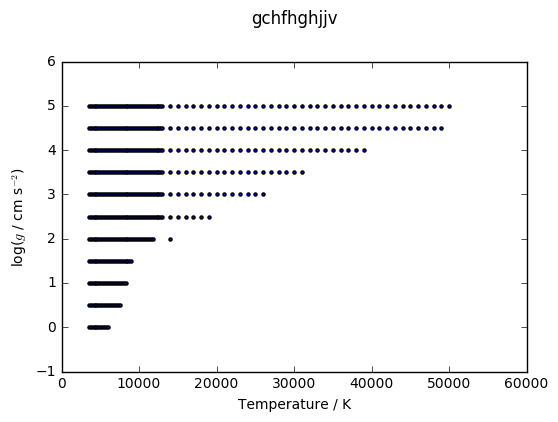

In [44]:
fig, ax = plt.subplots()
#ax.axhline(y=5.0, color='m', linestyle='--')
# Create a continuous norm to map from data points to colors | np.log10((Dthm+1).min()),np.log10((Dthm+1).max())
ax.scatter(T_Av0zs,log_g_Av0zs,marker='.')
ax.set_xlabel('Temperature / K')
ax.set_ylabel('log($g$ / cm s$^{-2}$)')
#ax.set_xlim(['5.02, 0.1])
#ax.set_ylim([0, 0.1])
#plt.show()
#ax.set_title('gchfhghjjv', y=1.1)
fig.savefig('gaia_spectra/gaia_graphs/hgchgftf.pdf', bbox_inches='tight')